# MC: Understand the generator status

The interplay of generator status and simulator status is discussed in the chaptor on the simulator status.

In [10]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot

from lcio_checks.mc.simulation import add_simulation_info
from lcio_checks.util import config, load_or_make

f = uproot.open(f"{config['data_dir']}/P2f_z_eehiq.root")["MyLCTuple"]
mc = f.arrays(filter_name="mc*", entry_stop=-1)
mc = add_simulation_info(mc)

In [11]:
def validate_my_explanation(mc):
    mc4 = mc[mc.mcgst == 4]
    assert all(ak.num(mc4.mcgst) == 2)
    assert all(mc4.mcpdg[:, 0] == 11)
    assert all(mc4.mcpdg[:, 1] == -11)
    assert all(ak.flatten(mc4.mcmox) == 0.8750143)
    assert all(ak.flatten(mc4.mcmoy) == 0)
    assert all(np.abs(ak.flatten(mc4.mcmoz)) == 125)
    assert ak.min(mc4.mcene) == ak.max(mc4.mcene)
    assert abs(mc4.mcene[0][0] - 125) < 0.1  # E_e^2 = (M_e^2 + p_z_e^2)
    assert all(ak.flatten(mc4.mcvtx) == 0)
    assert all(ak.flatten(mc4.mcvty) == 0)
    assert all(ak.flatten(mc4.mcvtx == mc4.mcepx))
    assert all(ak.flatten(mc4.mcvty == mc4.mcepy))
    assert all(ak.flatten(mc4.mcvtz == mc4.mcepz))


validate_my_explanation(mc)

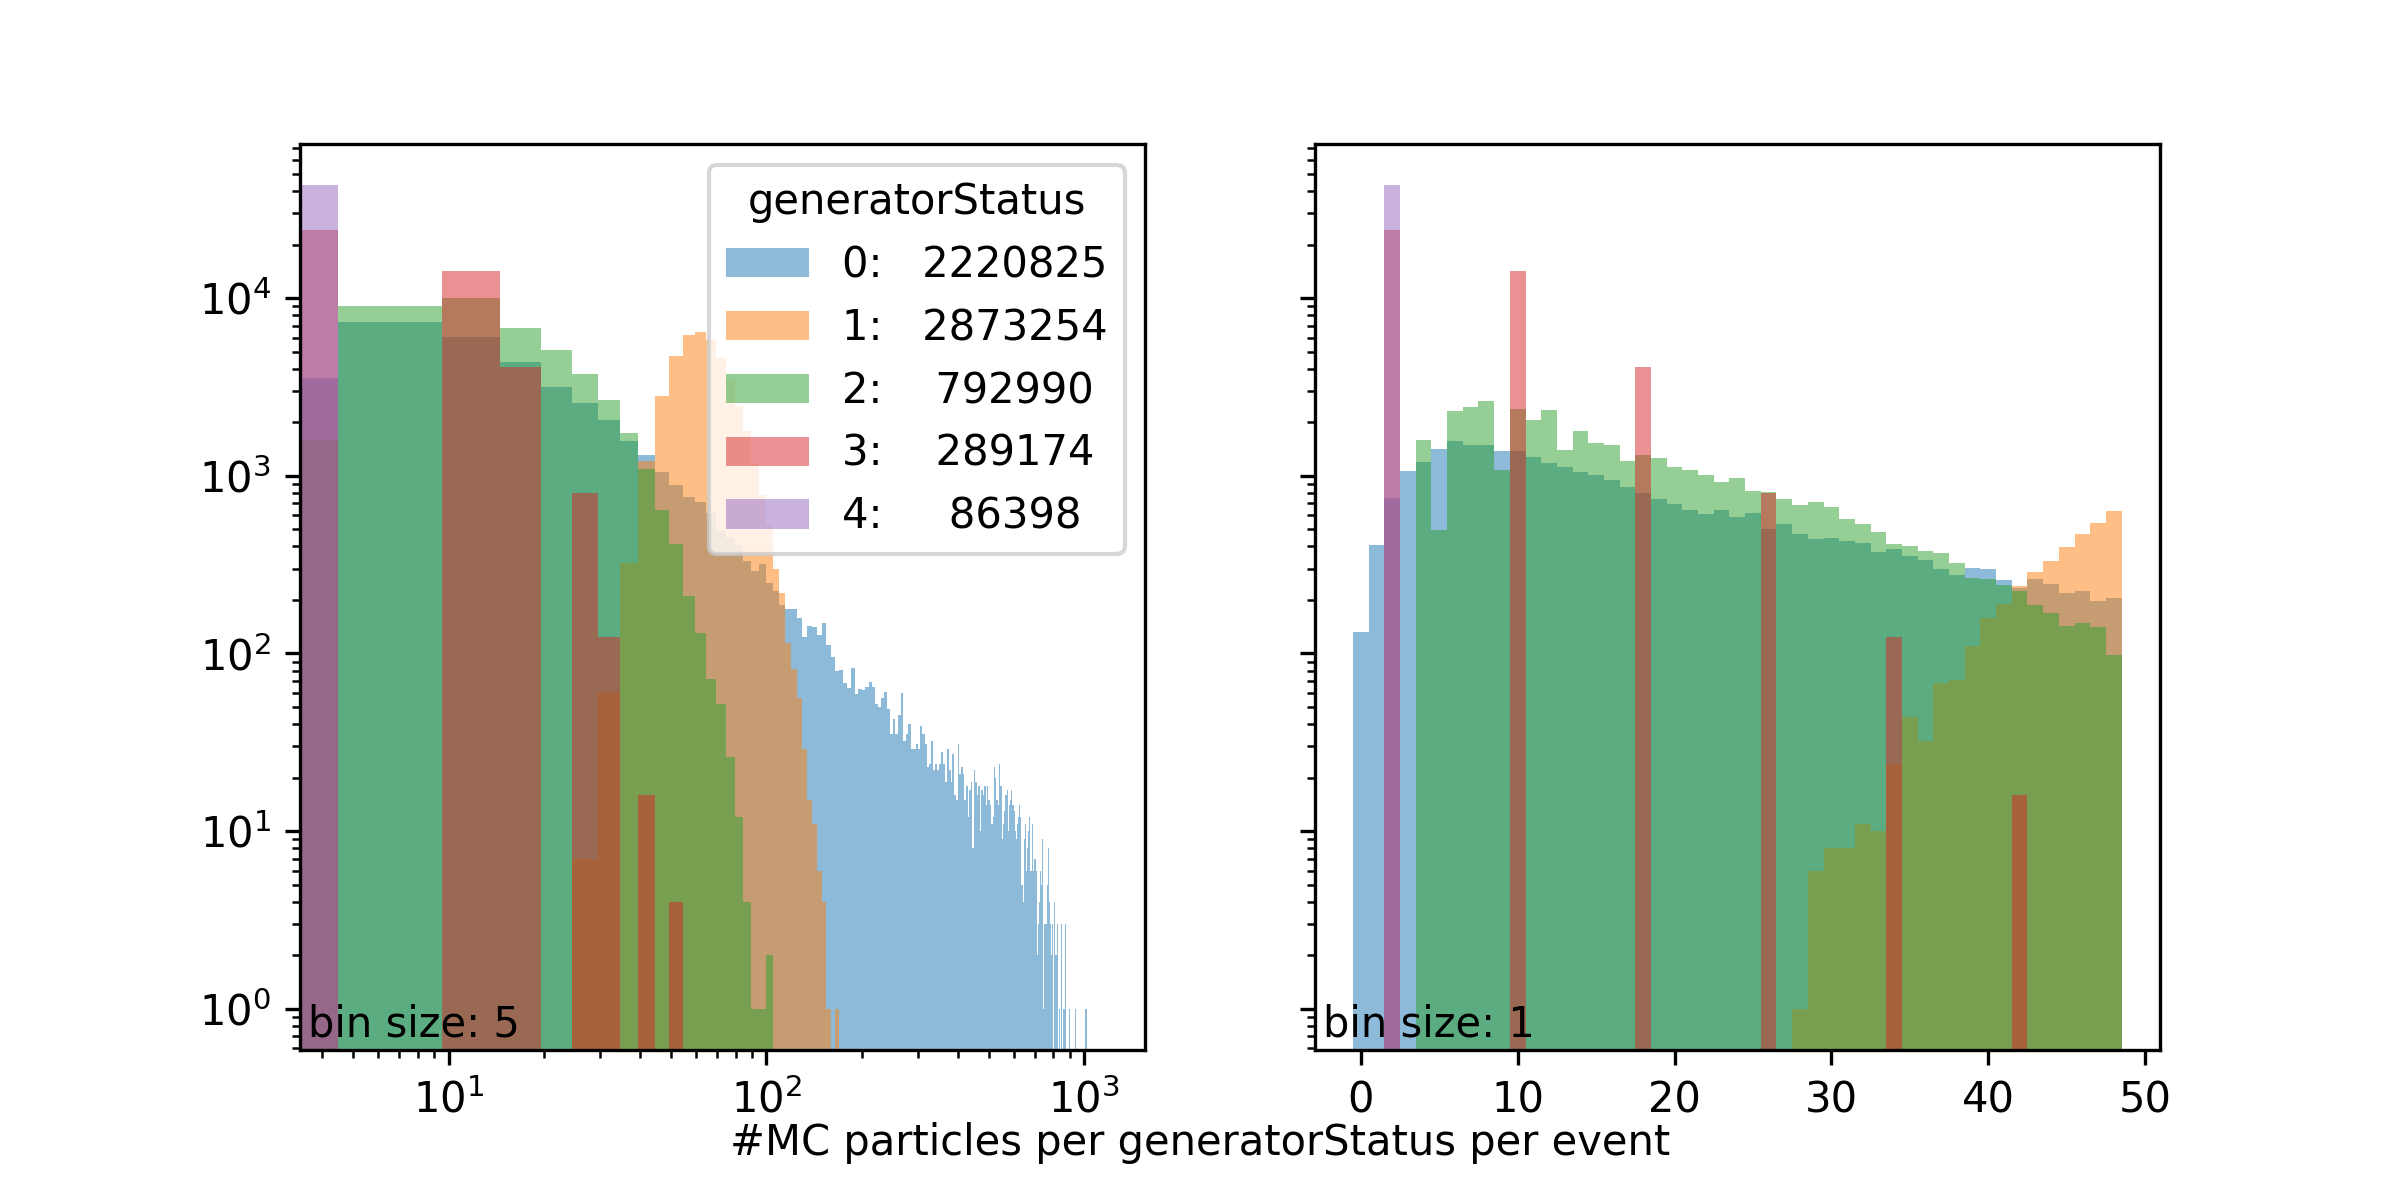

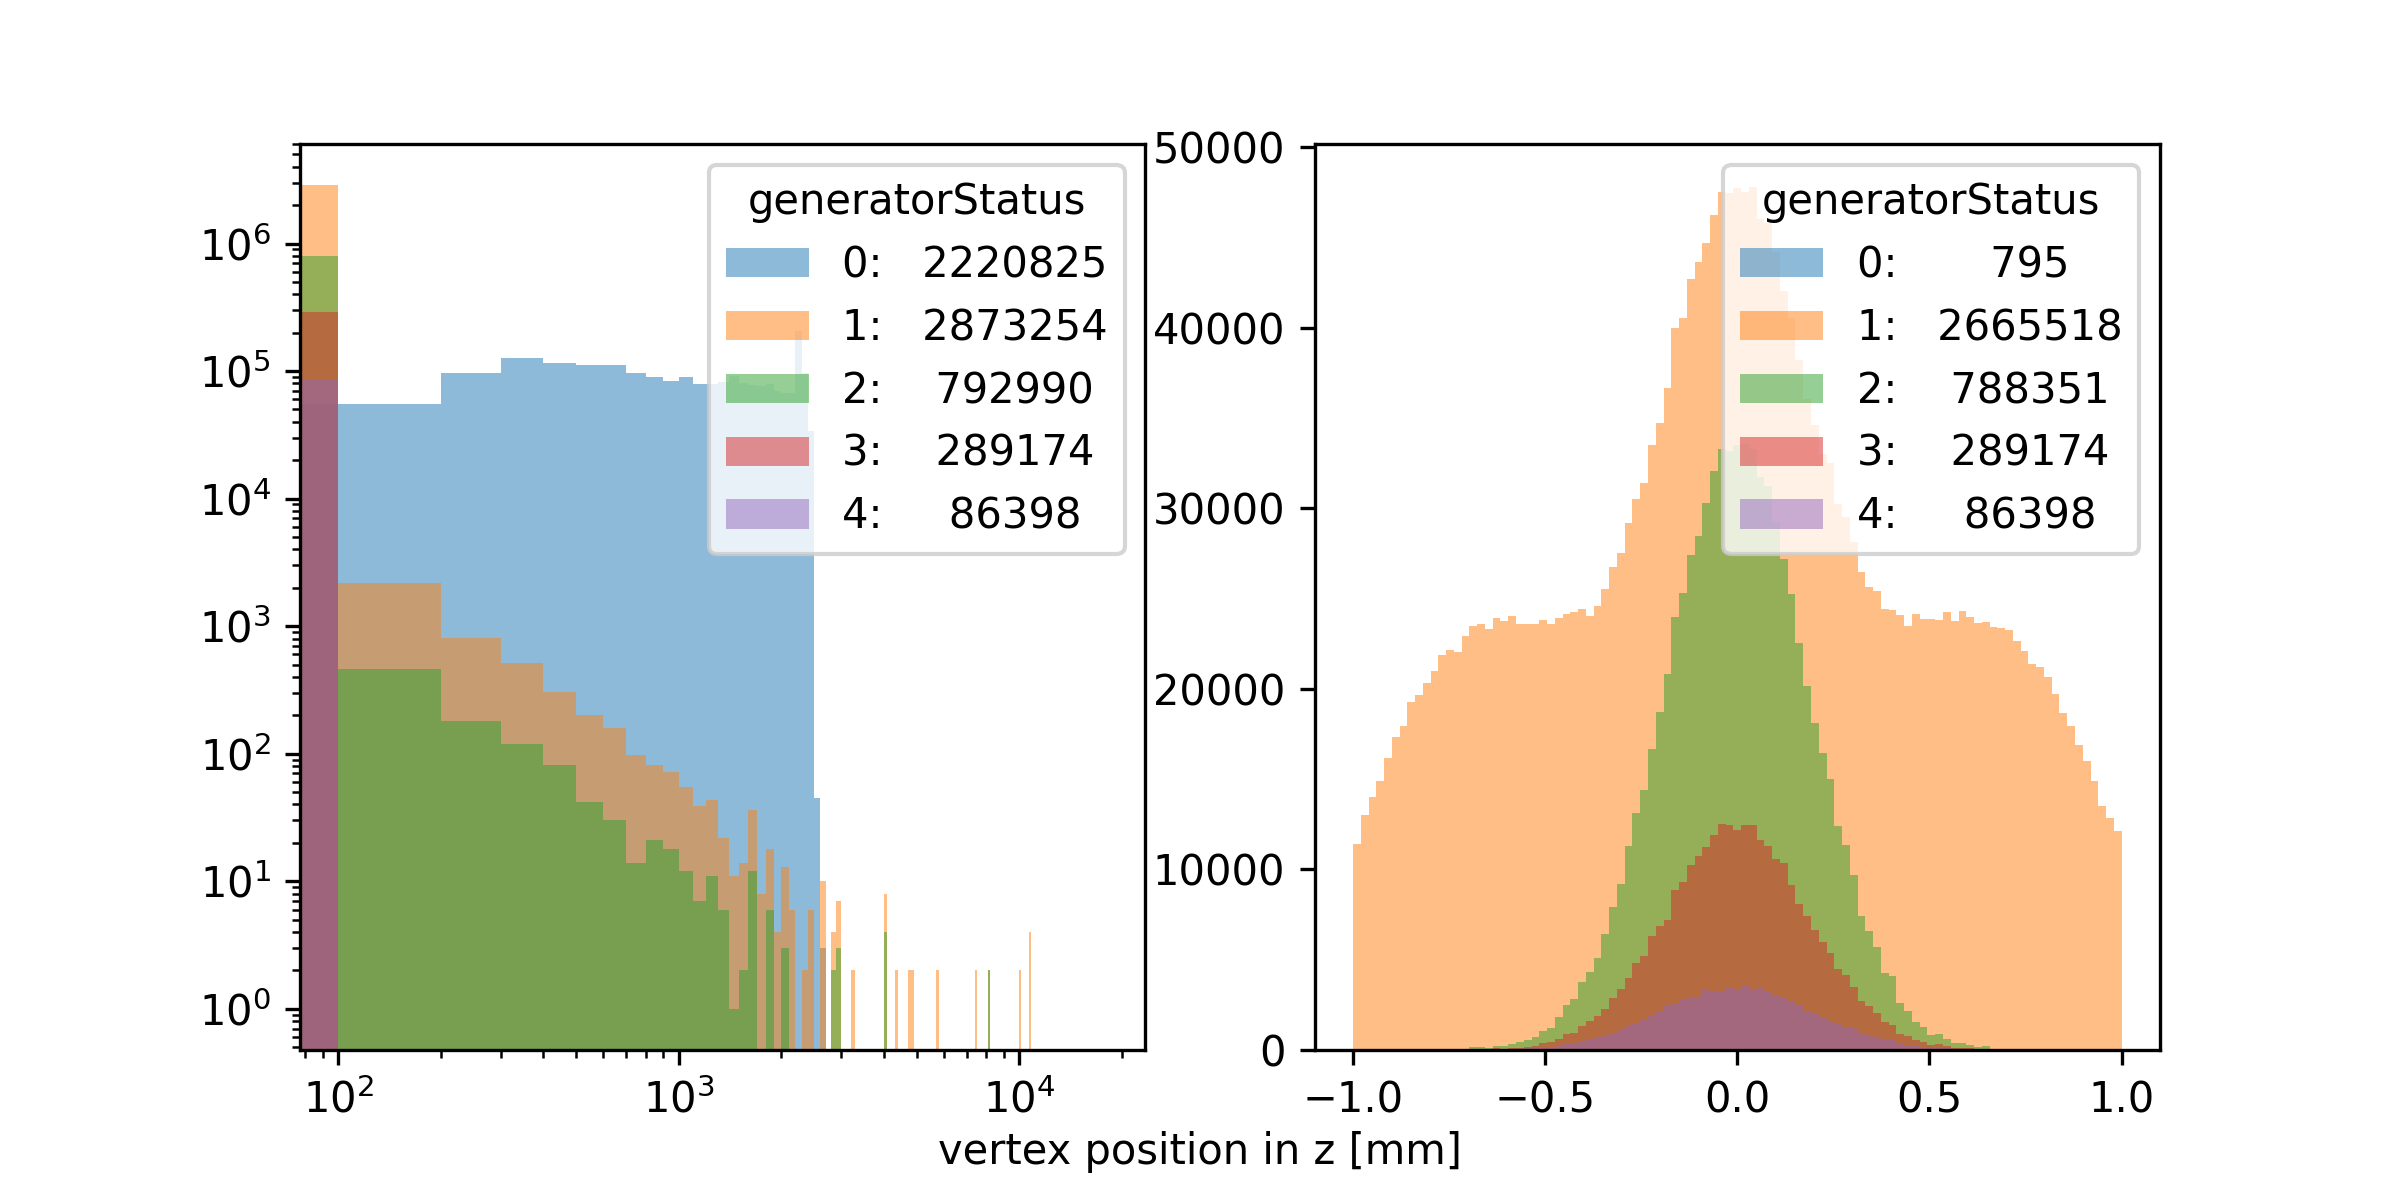

In [12]:
from lcio_checks.mc.generation import (
    count_mc_per_generator_status,
    vertex_in_z_per_generator_status,
)

fig1 = count_mc_per_generator_status(mc)
fig2 = vertex_in_z_per_generator_status(mc)

In [13]:
created_in_simu = np.unique(ak.flatten(mc[mc.isCreatedInSimulation].mcgst))
assert len(created_in_simu) == 1
assert created_in_simu[0] == 0  # Generator status 0

## Meaning of the generator status

Adapted from [LCIO docs](https://ilcsoft.desy.de/LCIO/current/doc/doxygen_api/html/classEVENT_1_1MCParticle.html)

- **0**: Created in simulation
- **1**: Undecayed particle, stable in the generator
- **2**: Particle decayed in the generator
- **3**: Documentation line (used for overlay?)
- **4**: Beam parameters

## Particle PDGs (per generator status)

In [14]:
@load_or_make(["pdg_counts.csv"])
def load_pdg_counts(mc):
    pdg_counts = {}
    for pdg in np.unique(ak.flatten(mc.mcpdg)):
        tmp_mc = mc[mc.mcpdg == pdg]
        pdg_counts[pdg] = {}
        for gen_status in range(5):
            pdg_counts[pdg][gen_status] = ak.sum(
                ak.num(tmp_mc[tmp_mc.mcgst == gen_status].mcpdg)
            )
    df = pd.DataFrame(pdg_counts)
    df.index.name = "generator status"
    return (df,)


(df,) = load_pdg_counts(mc, redo=True)
df = df.transpose()

## Energy in the event per generator status

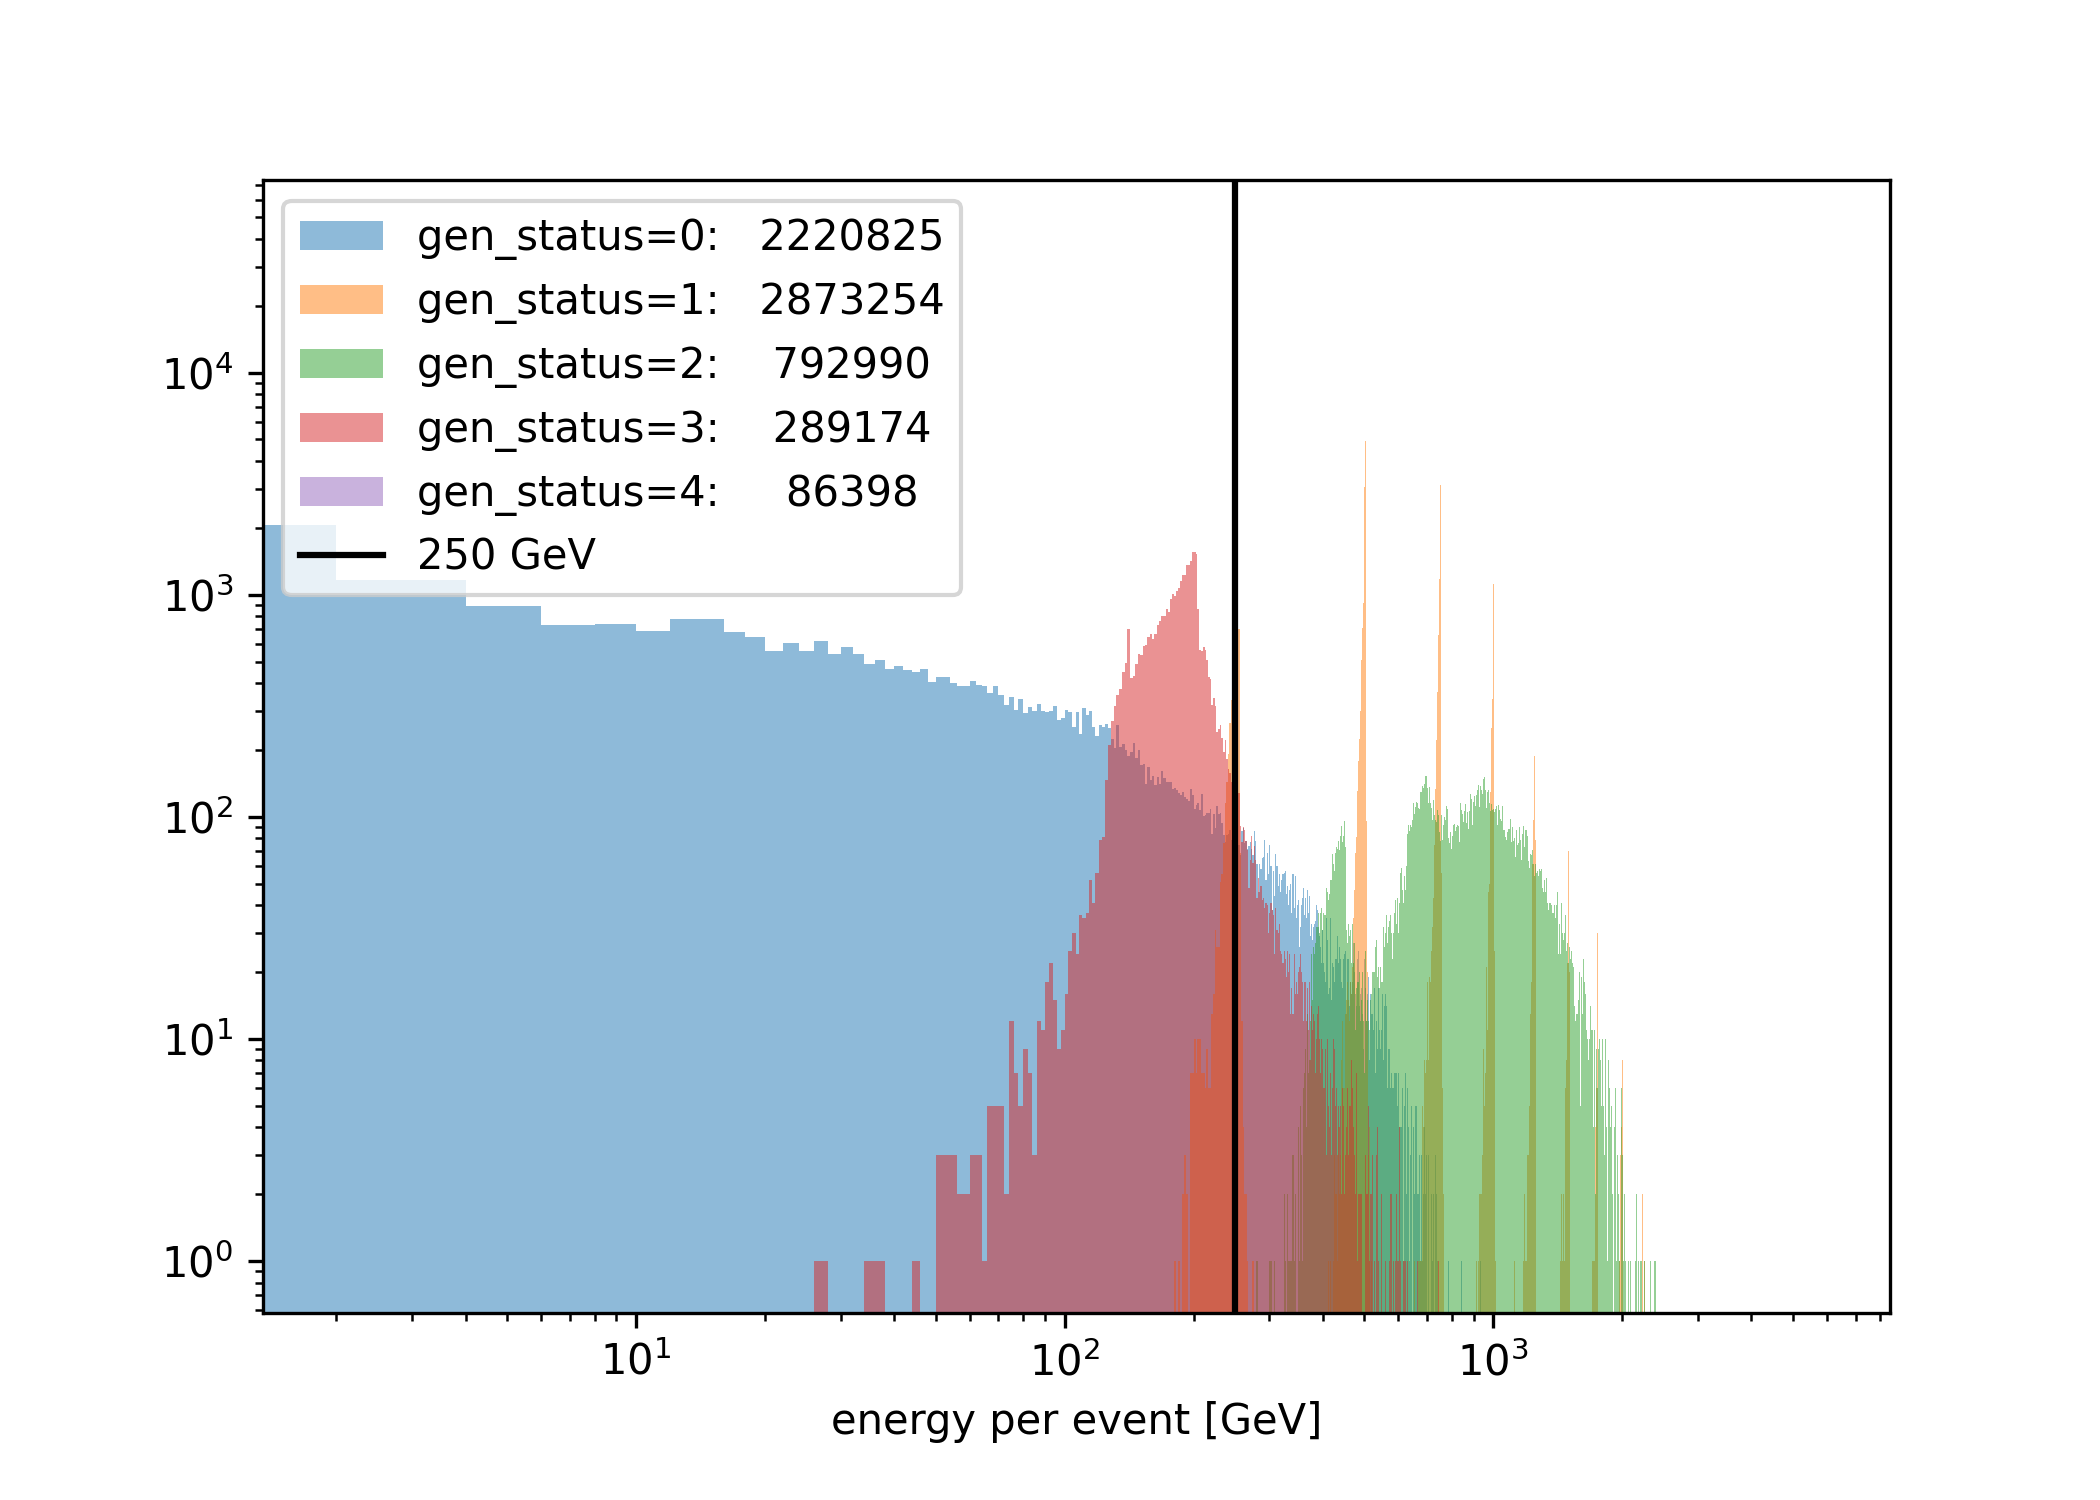

In [15]:
def _energy_per_generator_status(mc, per_event=True):
    if per_event:
        max_bin = ak.max(ak.sum(mc.mcene, axis=1))
    else:
        max_bin = ak.max(mc.mcene)
    bins = np.arange(0, max_bin, 2)

    fig, ax = plt.subplots(figsize=(7, 5))
    for i, gen_status in enumerate(range(5)):
        x = mc[mc.mcgst == gen_status].mcene
        if per_event:
            _x = ak.sum(x, axis=1)
        else:
            _x = ak.flatten(x)
        ax.hist(
            _x, bins=bins, label=f"{gen_status=}: {ak.sum(ak.num(x)):> 9}", alpha=0.5
        )
    if per_event:
        ax.set_xlabel("energy per event [GeV]")
    else:
        ax.set_xlabel("energy per MCP [GeV]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.axvline(250, color="black", label="250 GeV")
    # for i in range(2, 8):
    #     ax.axvline(i * 250, color="black")
    ax.legend(loc="upper left")
    return (fig,)


@load_or_make(["event_energy.png"])
def event_energy_per_generator_status(mc):
    return _energy_per_generator_status(mc, per_event=True)


event_energy_per_generator_status(mc, redo=True);

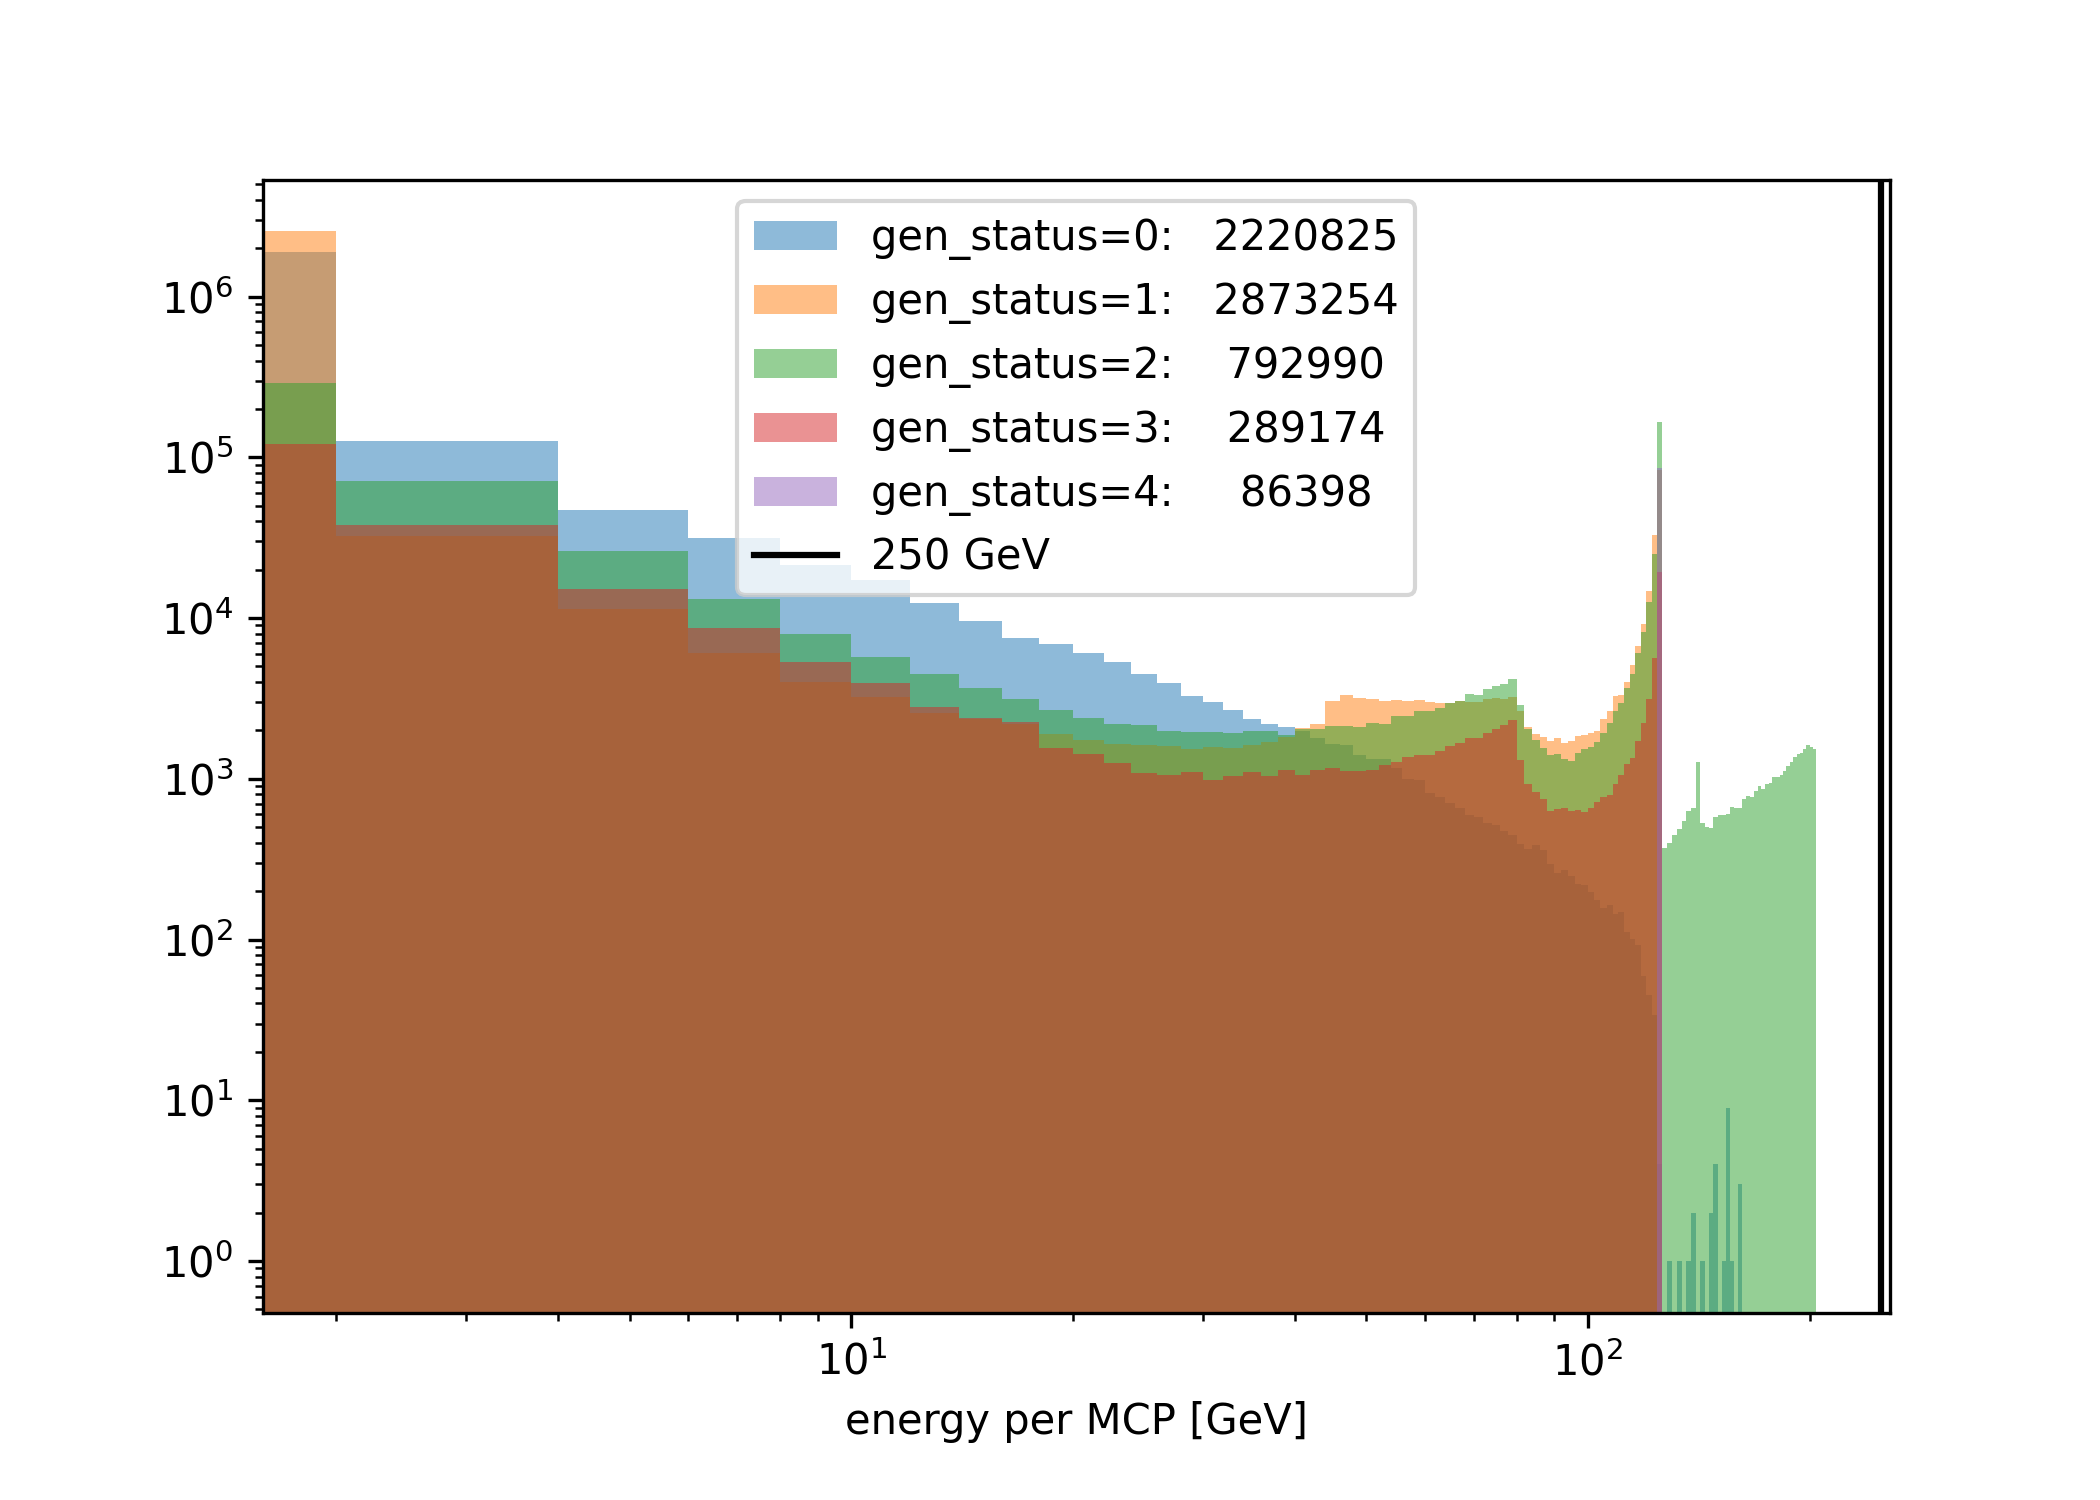

In [7]:
@load_or_make(["mcp_energy.png"])
def mcp_energy_per_generator_status(mc):
    return _energy_per_generator_status(mc, per_event=False)


mcp_energy_per_generator_status(mc, redo=True);

## Appendix: Some more distributions per generator status

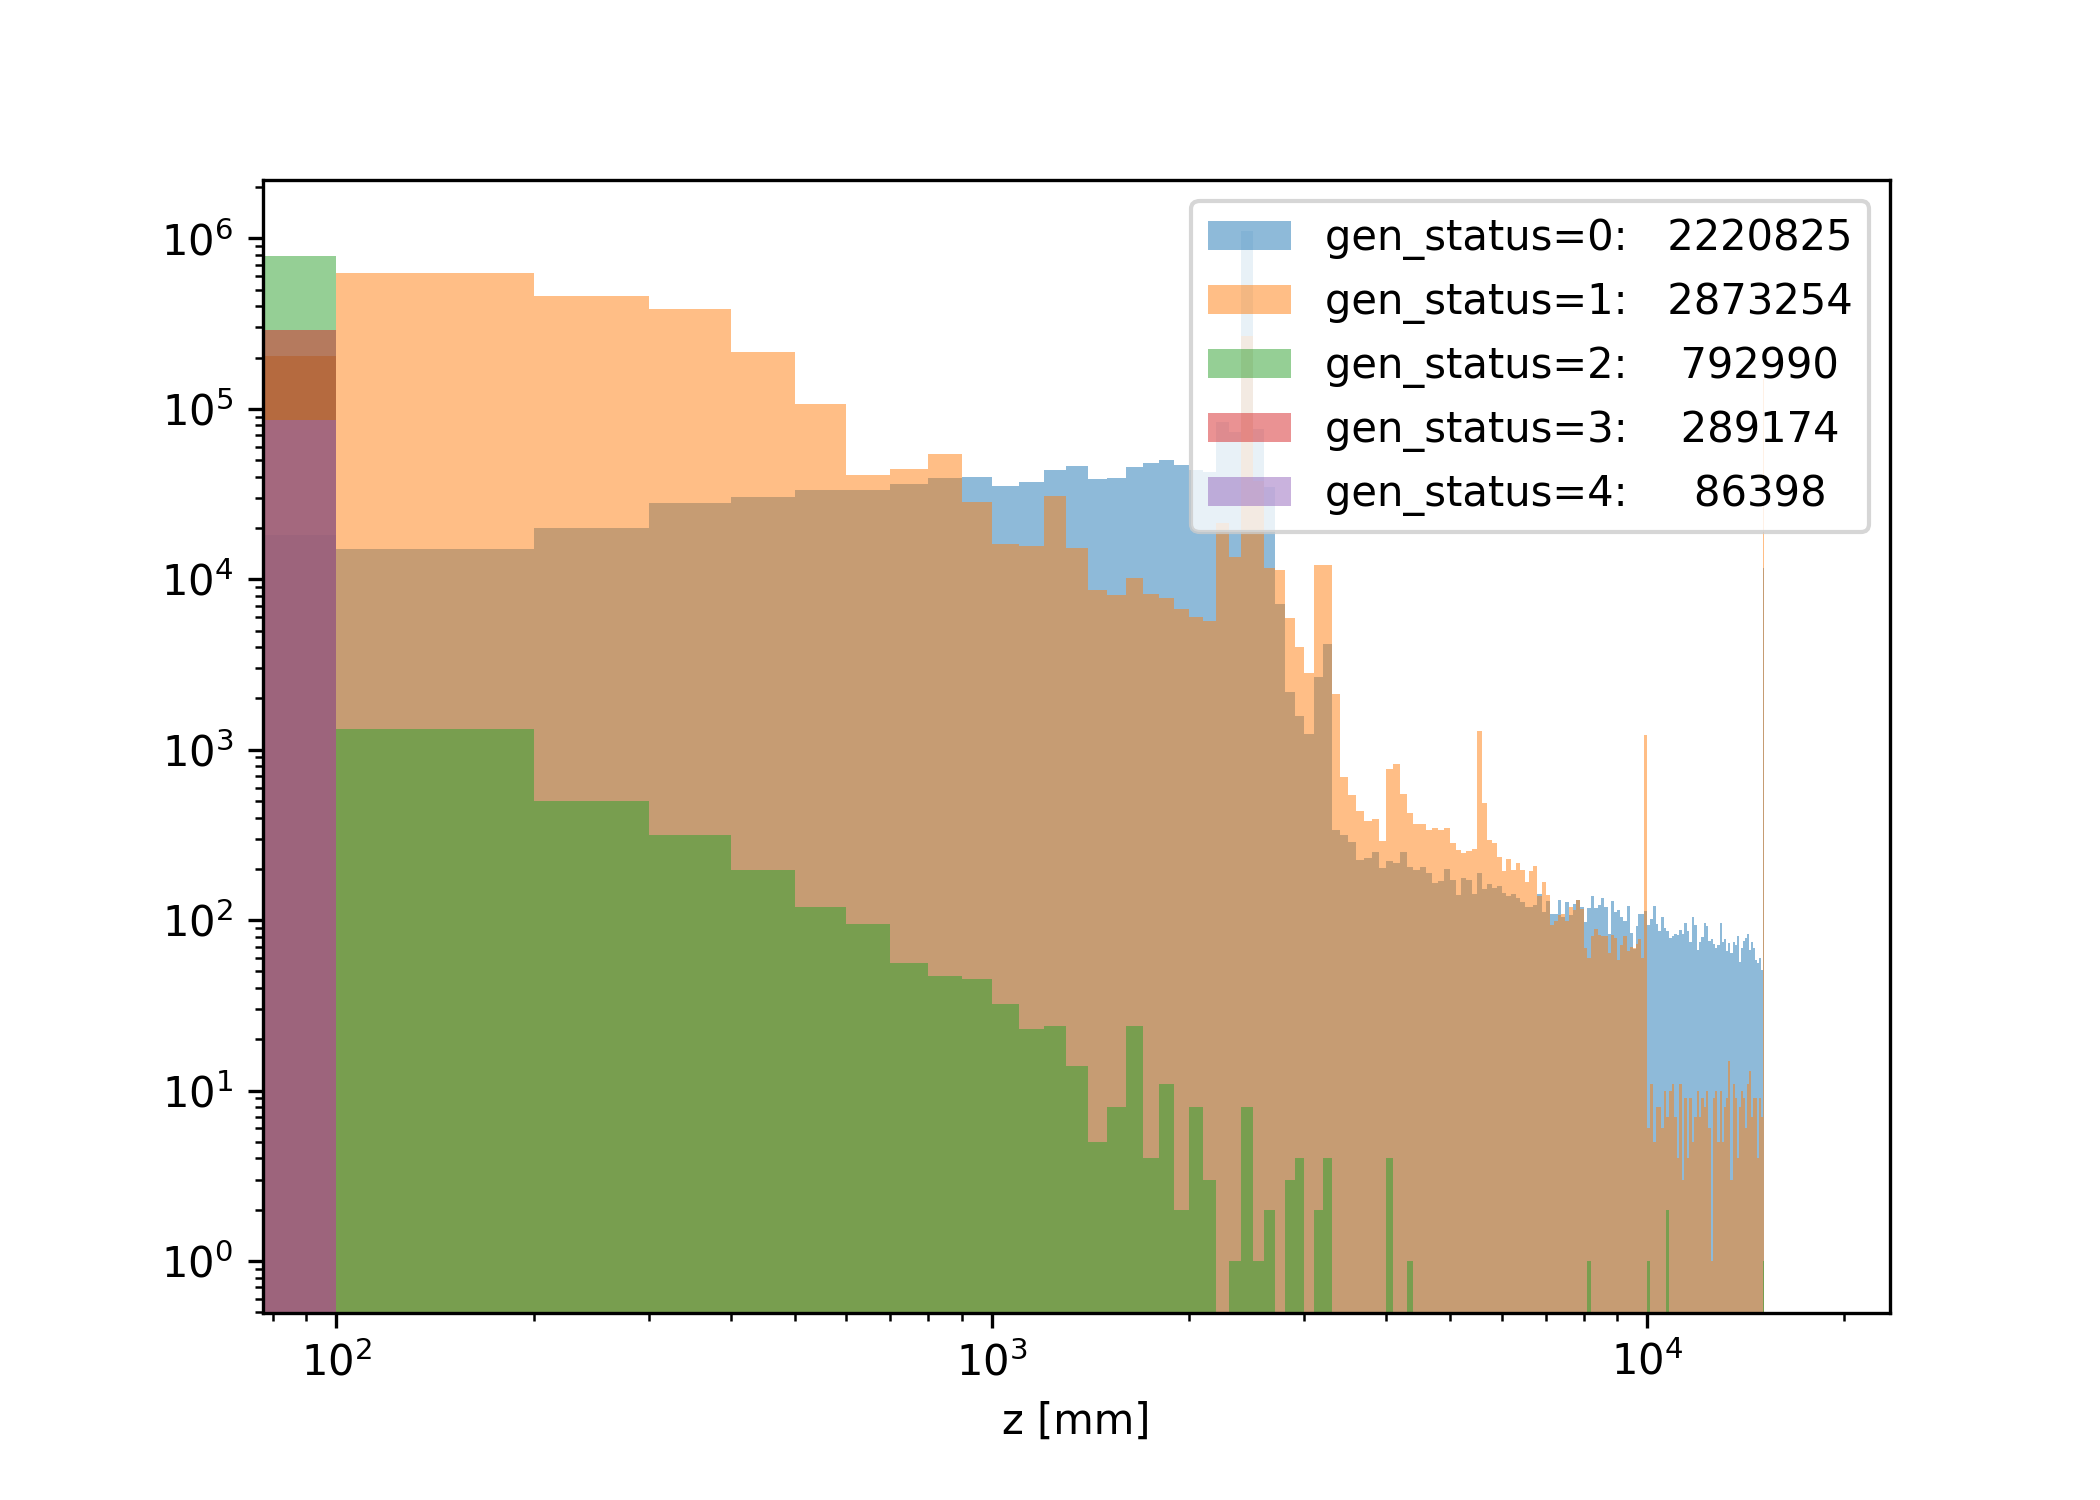

In [8]:
@load_or_make(["mcepz_log.png"])
def end_point_z_per_generator_status(mc):
    vtx_z = np.abs(mc.mcepz)
    bins1 = np.arange(0, ak.max(vtx_z), 100)
    fig, ax = plt.subplots(figsize=(7, 5))
    for i, gen_status in enumerate(range(5)):
        x = ak.flatten(vtx_z[mc.mcgst == gen_status])
        ax.hist(x, bins=bins1, label=f"{gen_status=}: {len(x):> 9}", alpha=0.5)
    ax.set_xlabel("z [mm]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    return (fig,)


end_point_z_per_generator_status(mc);

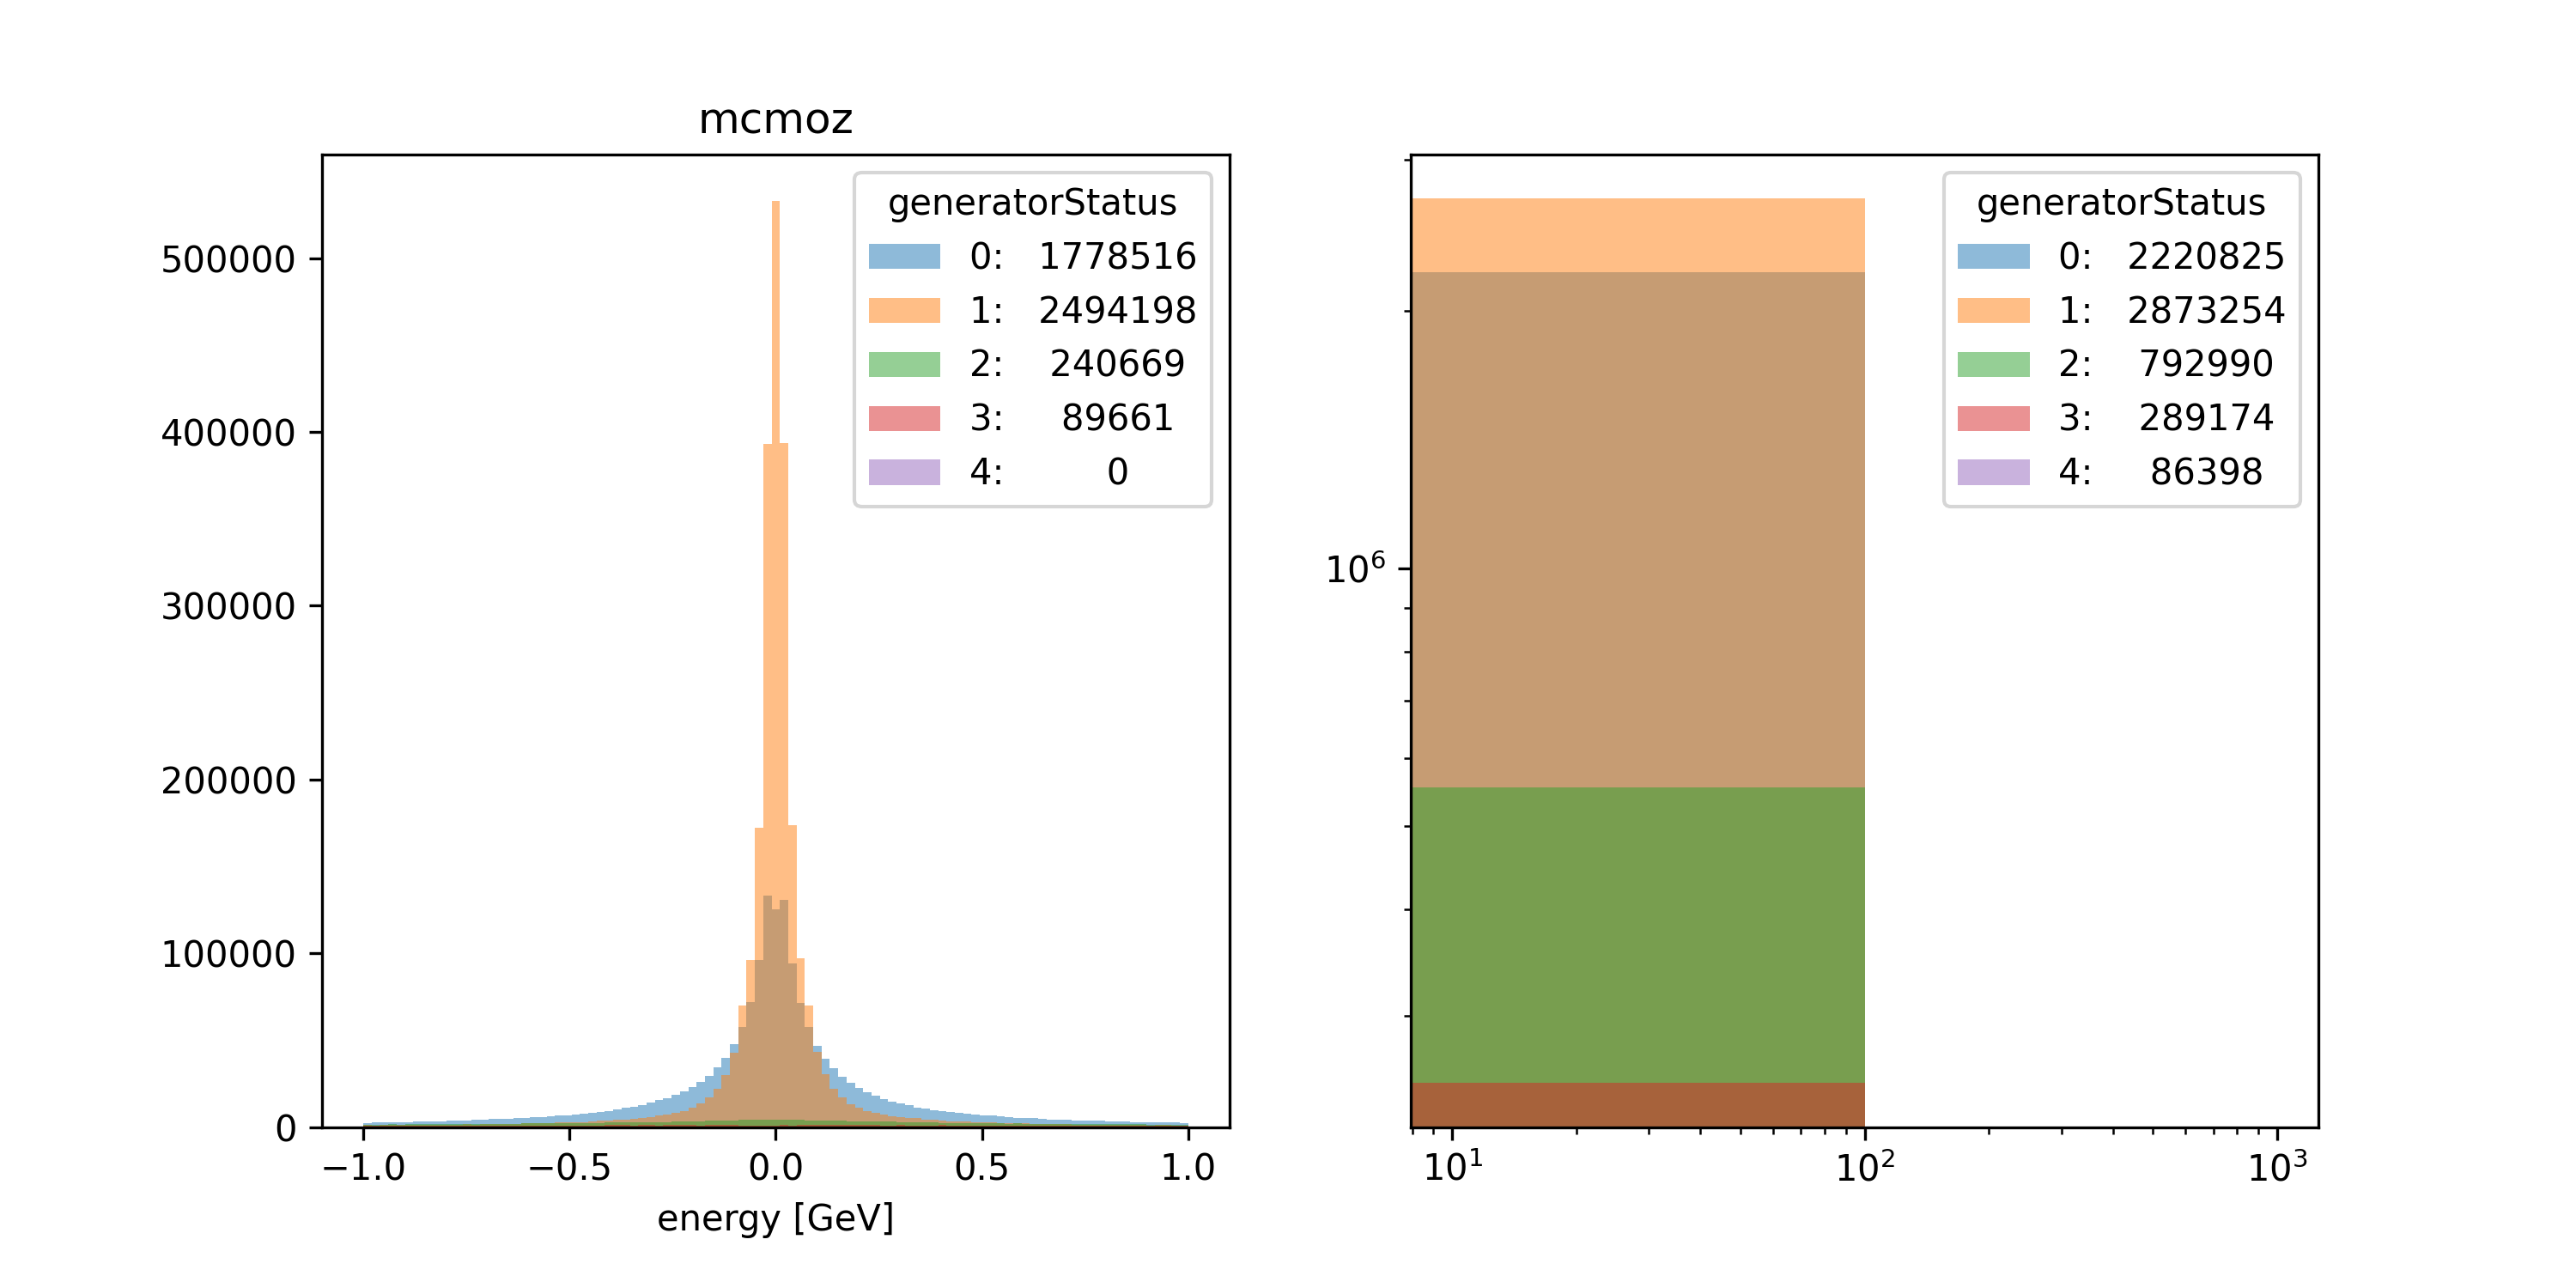

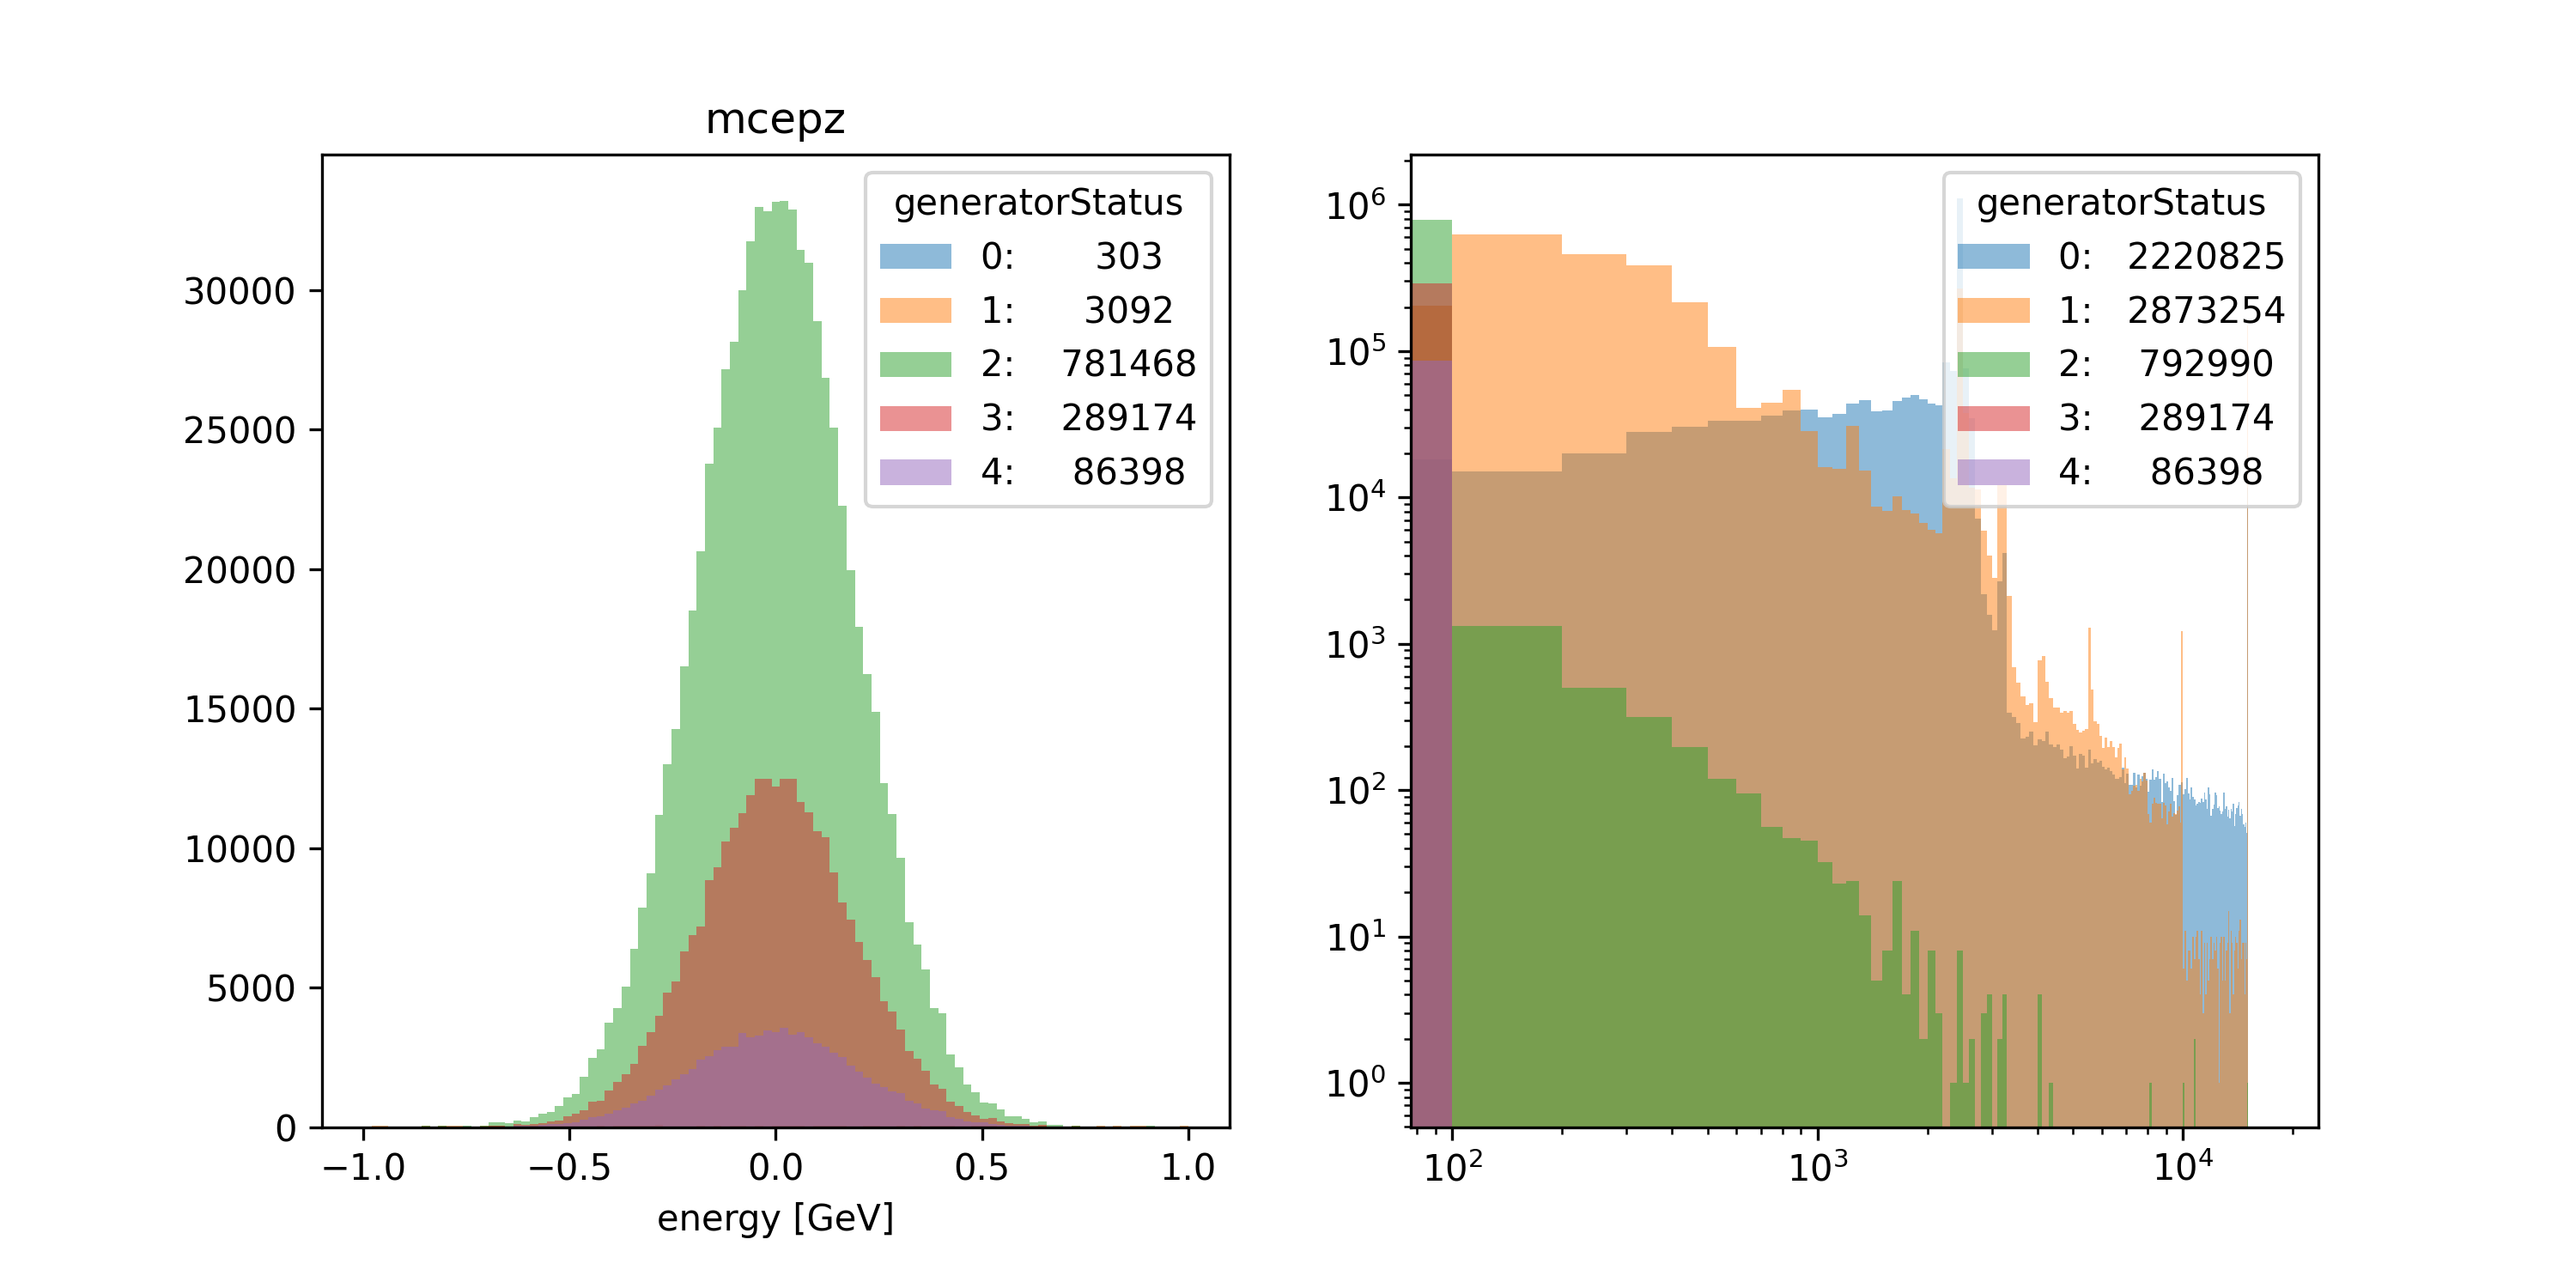

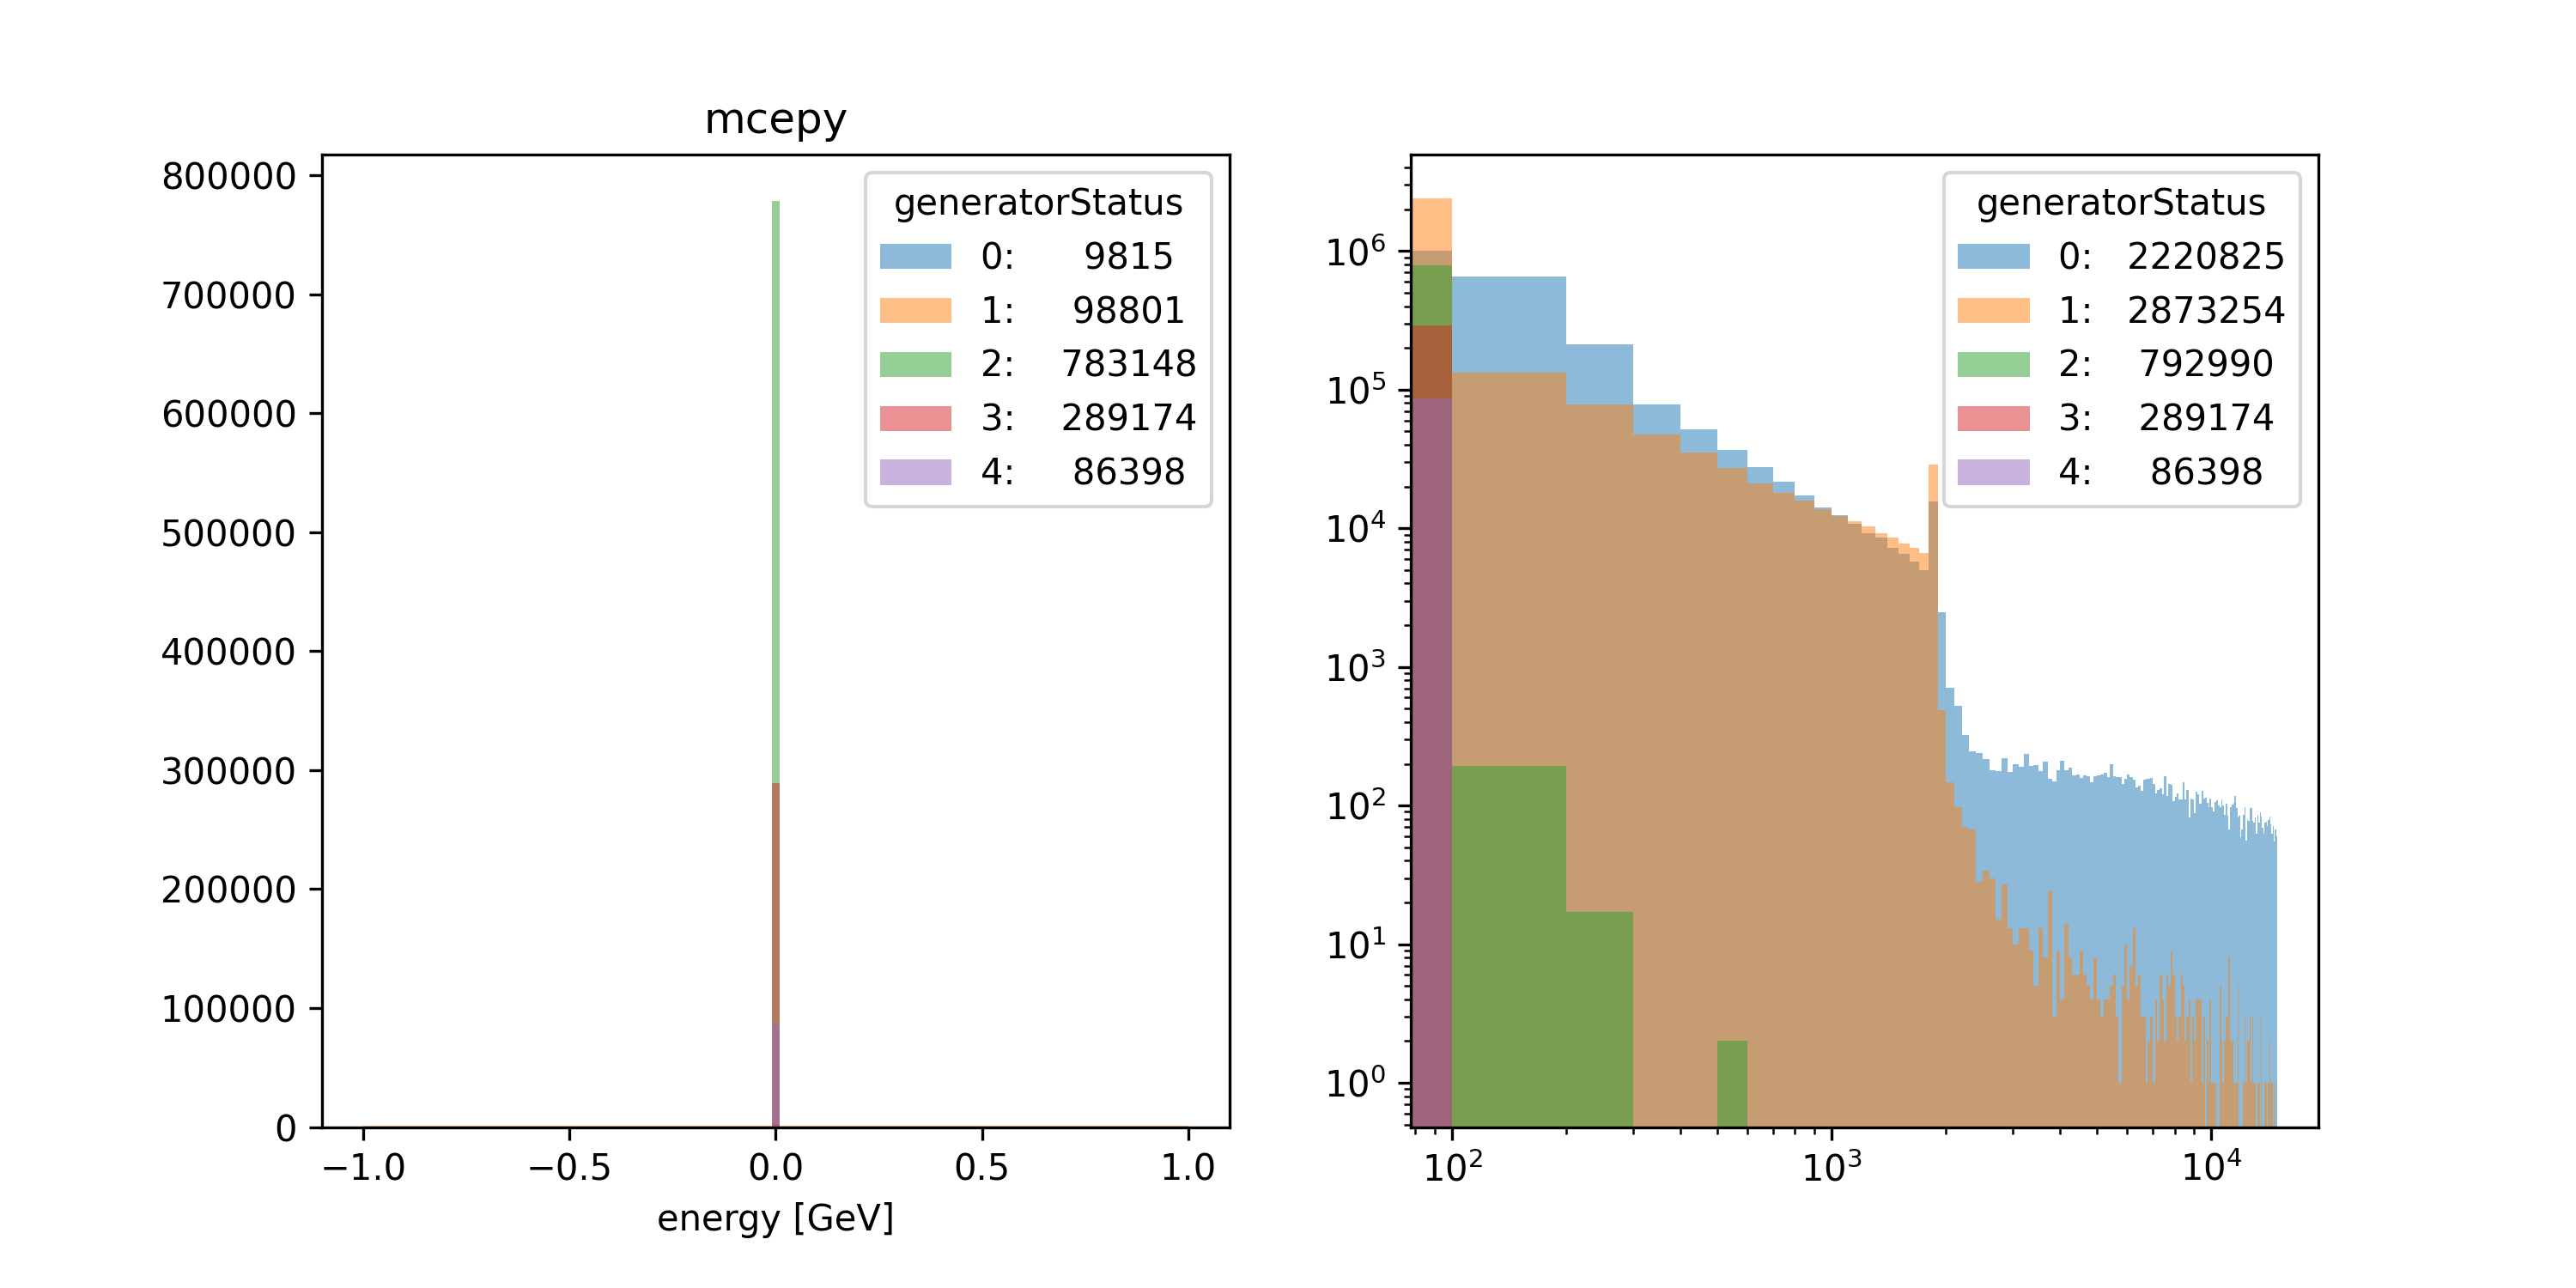

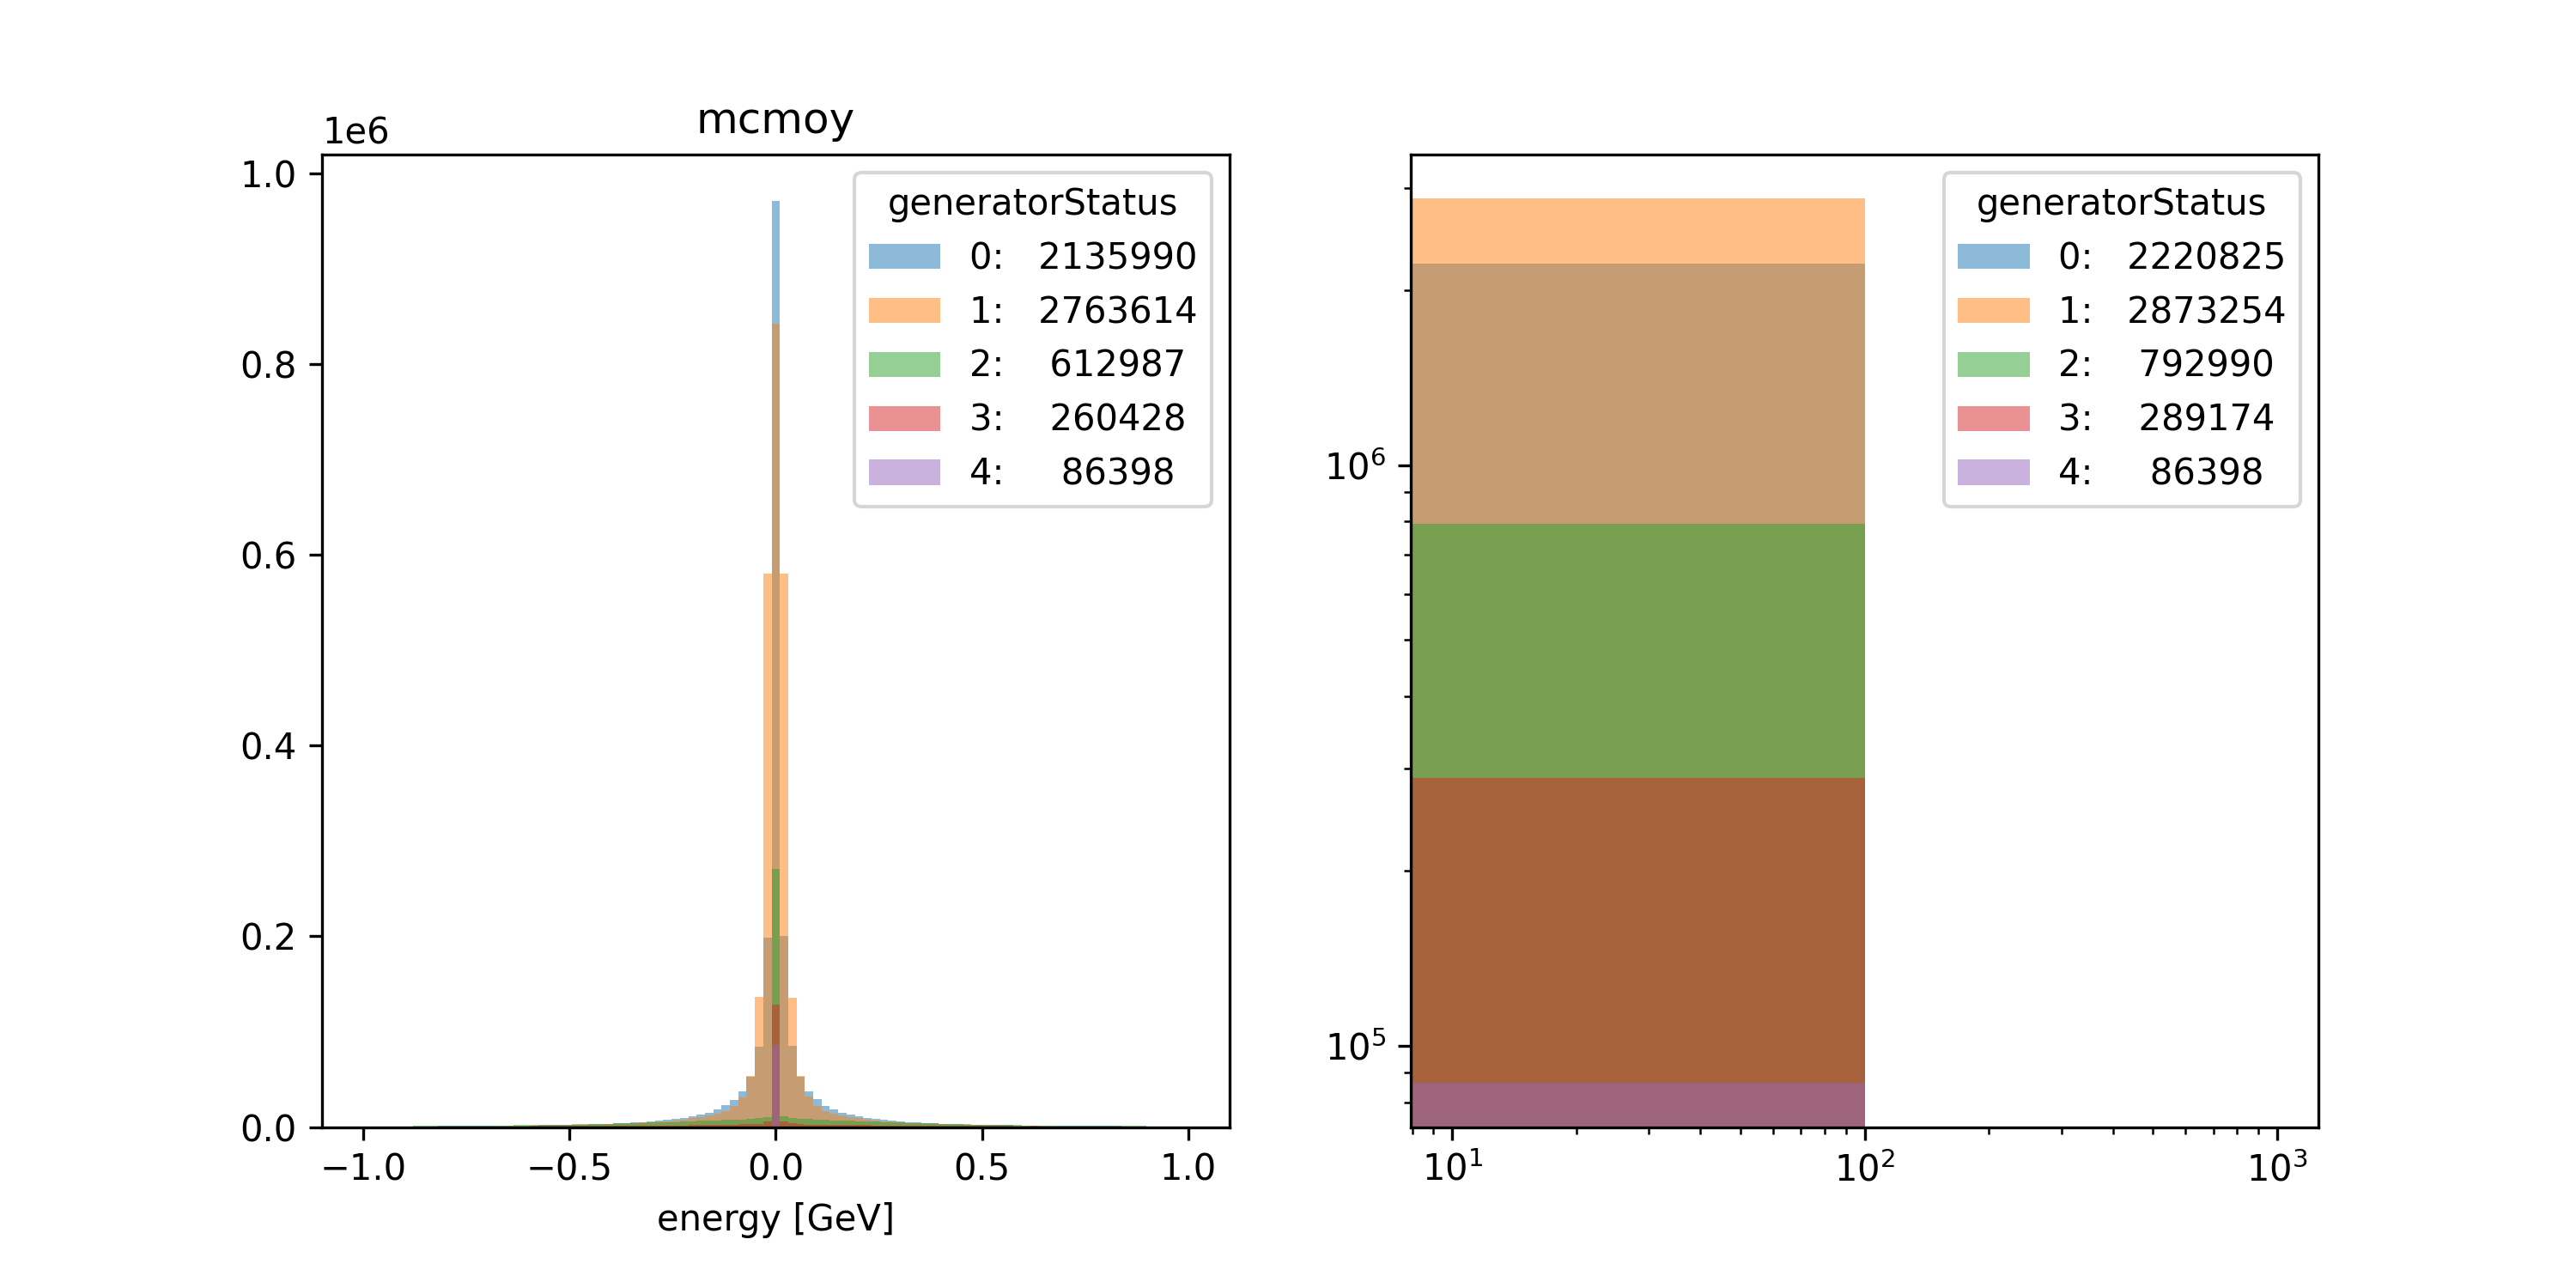

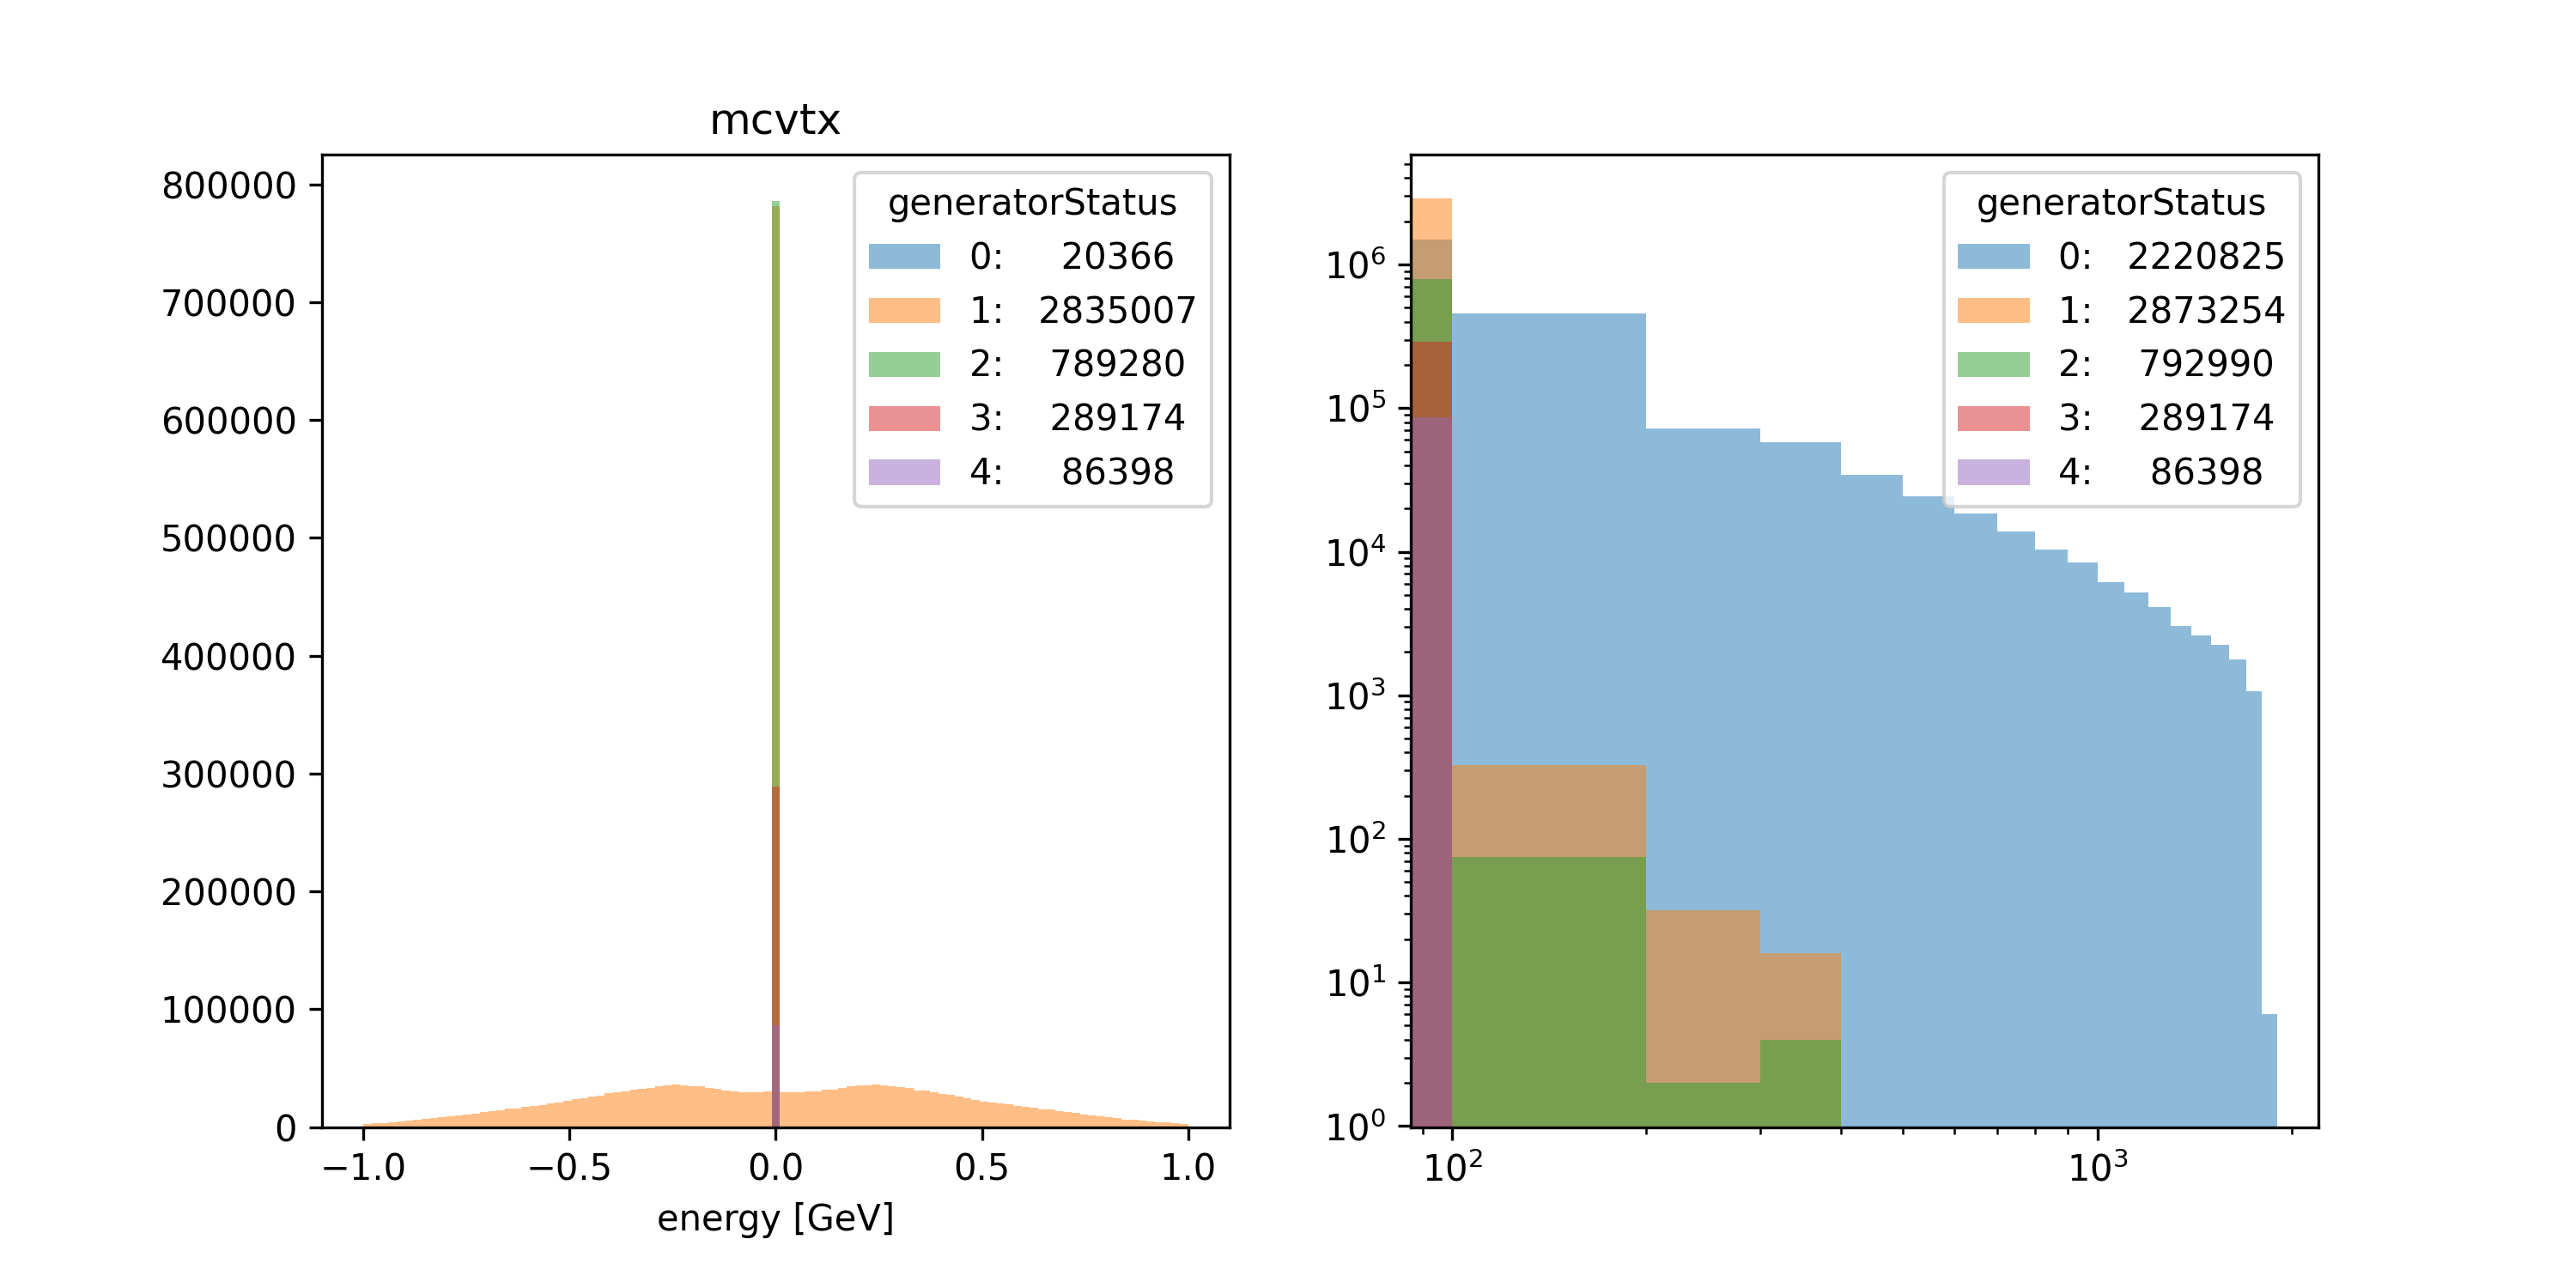

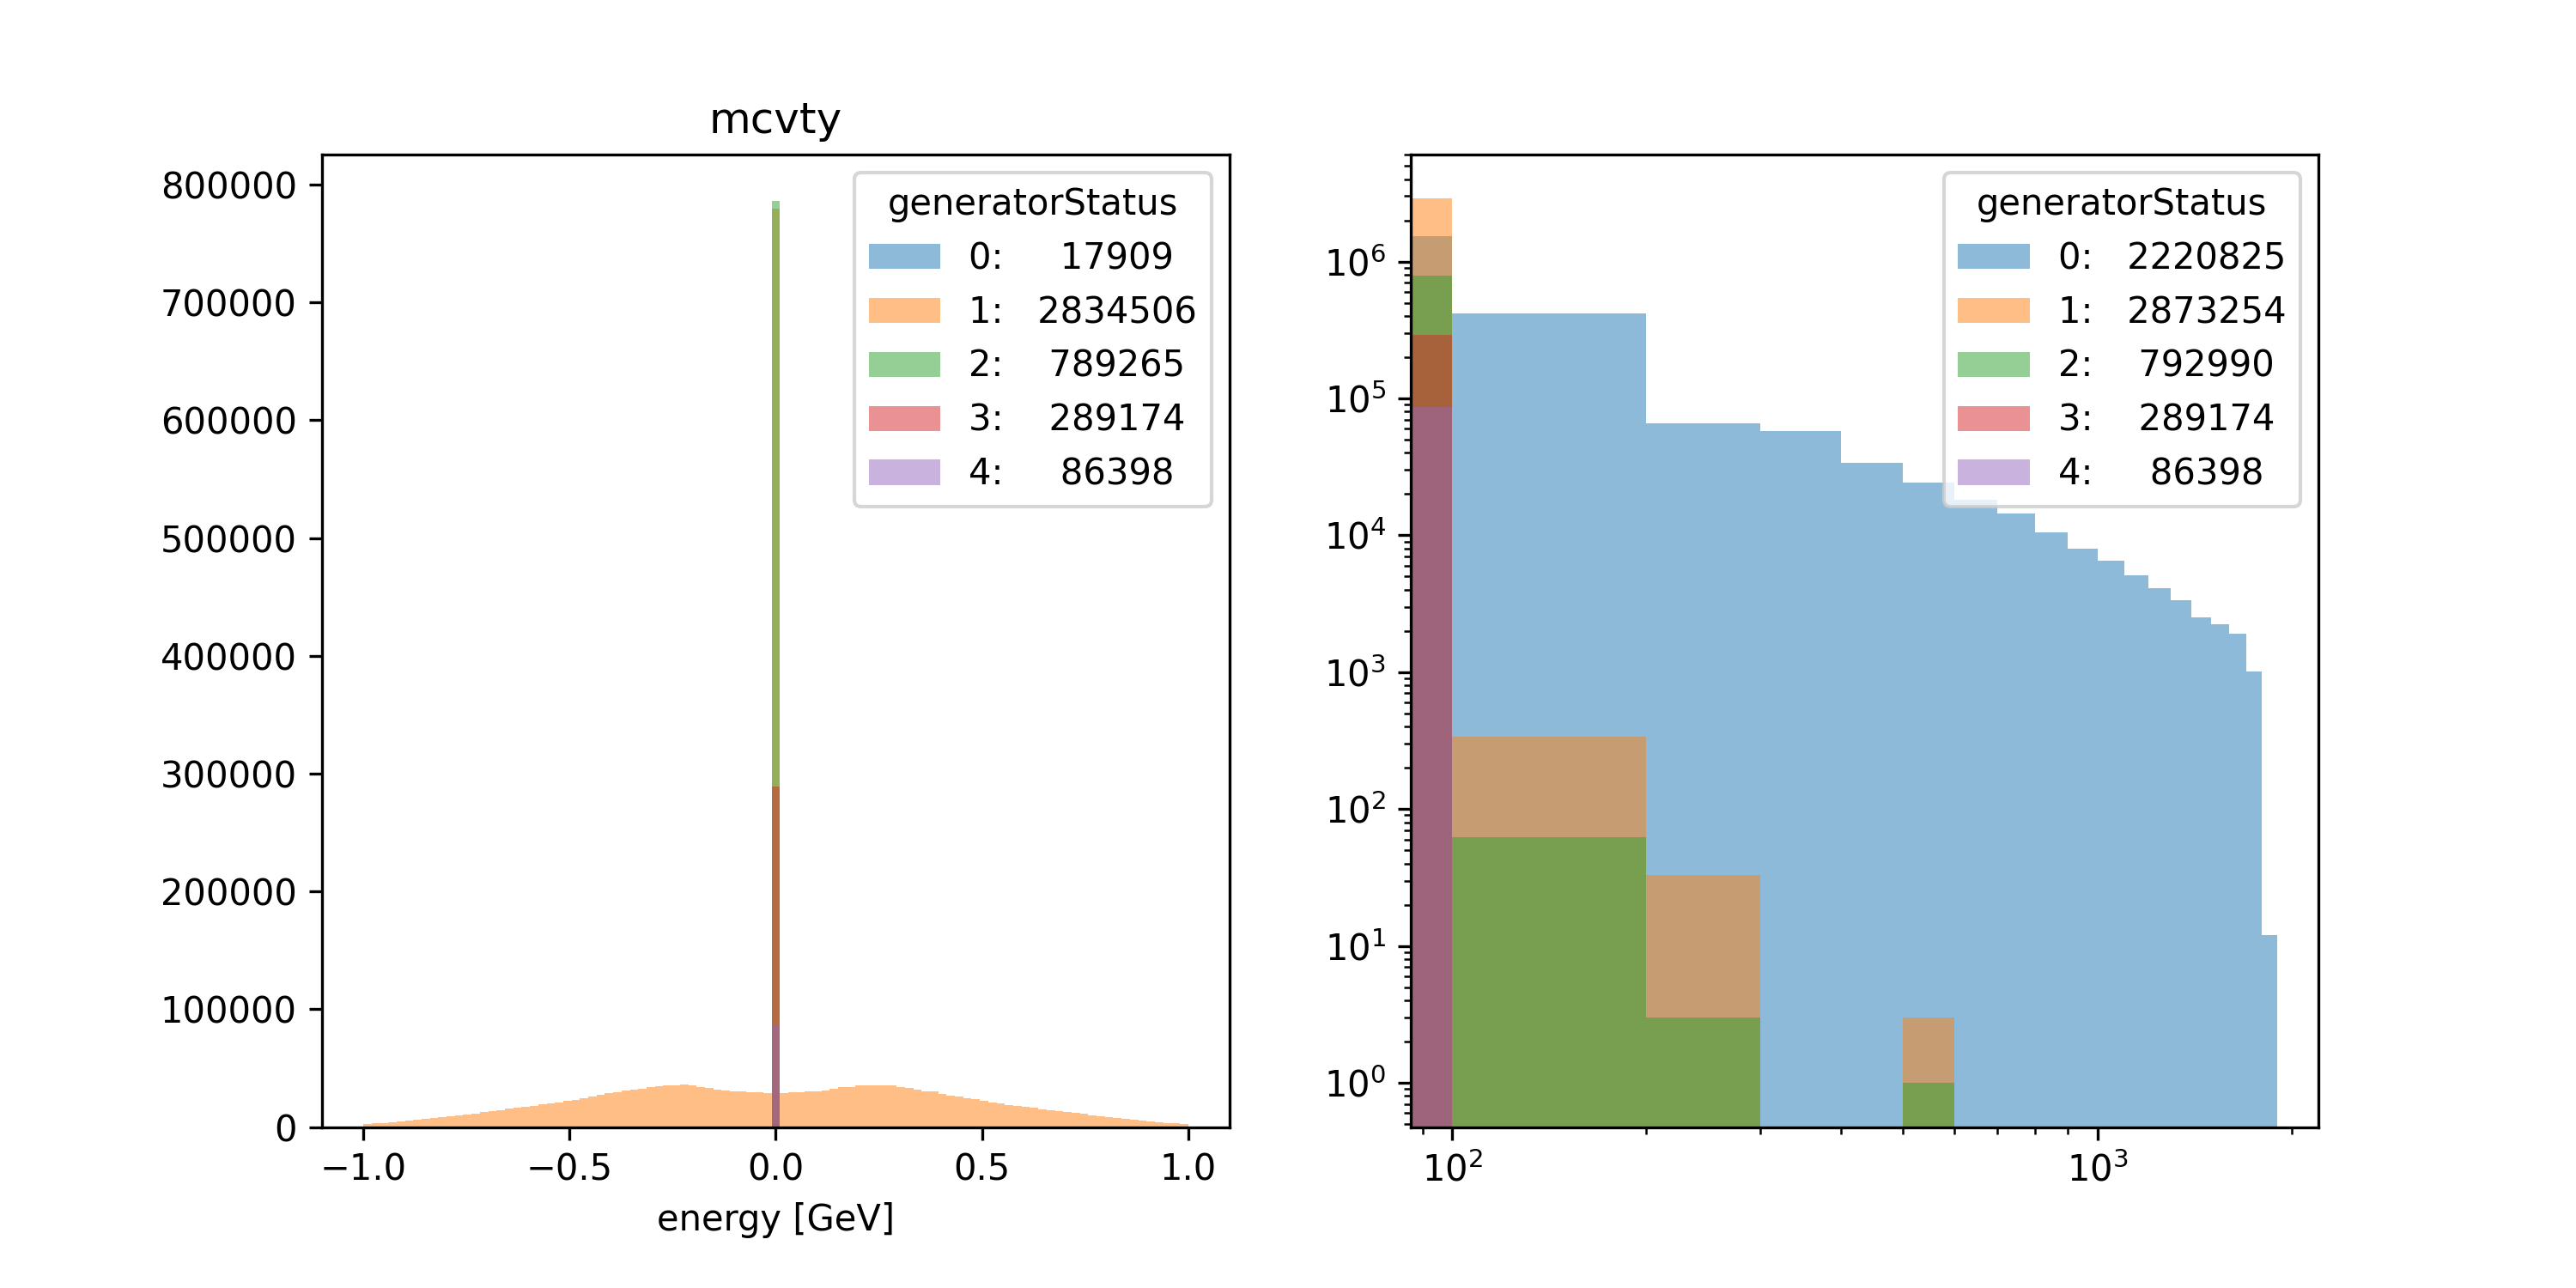

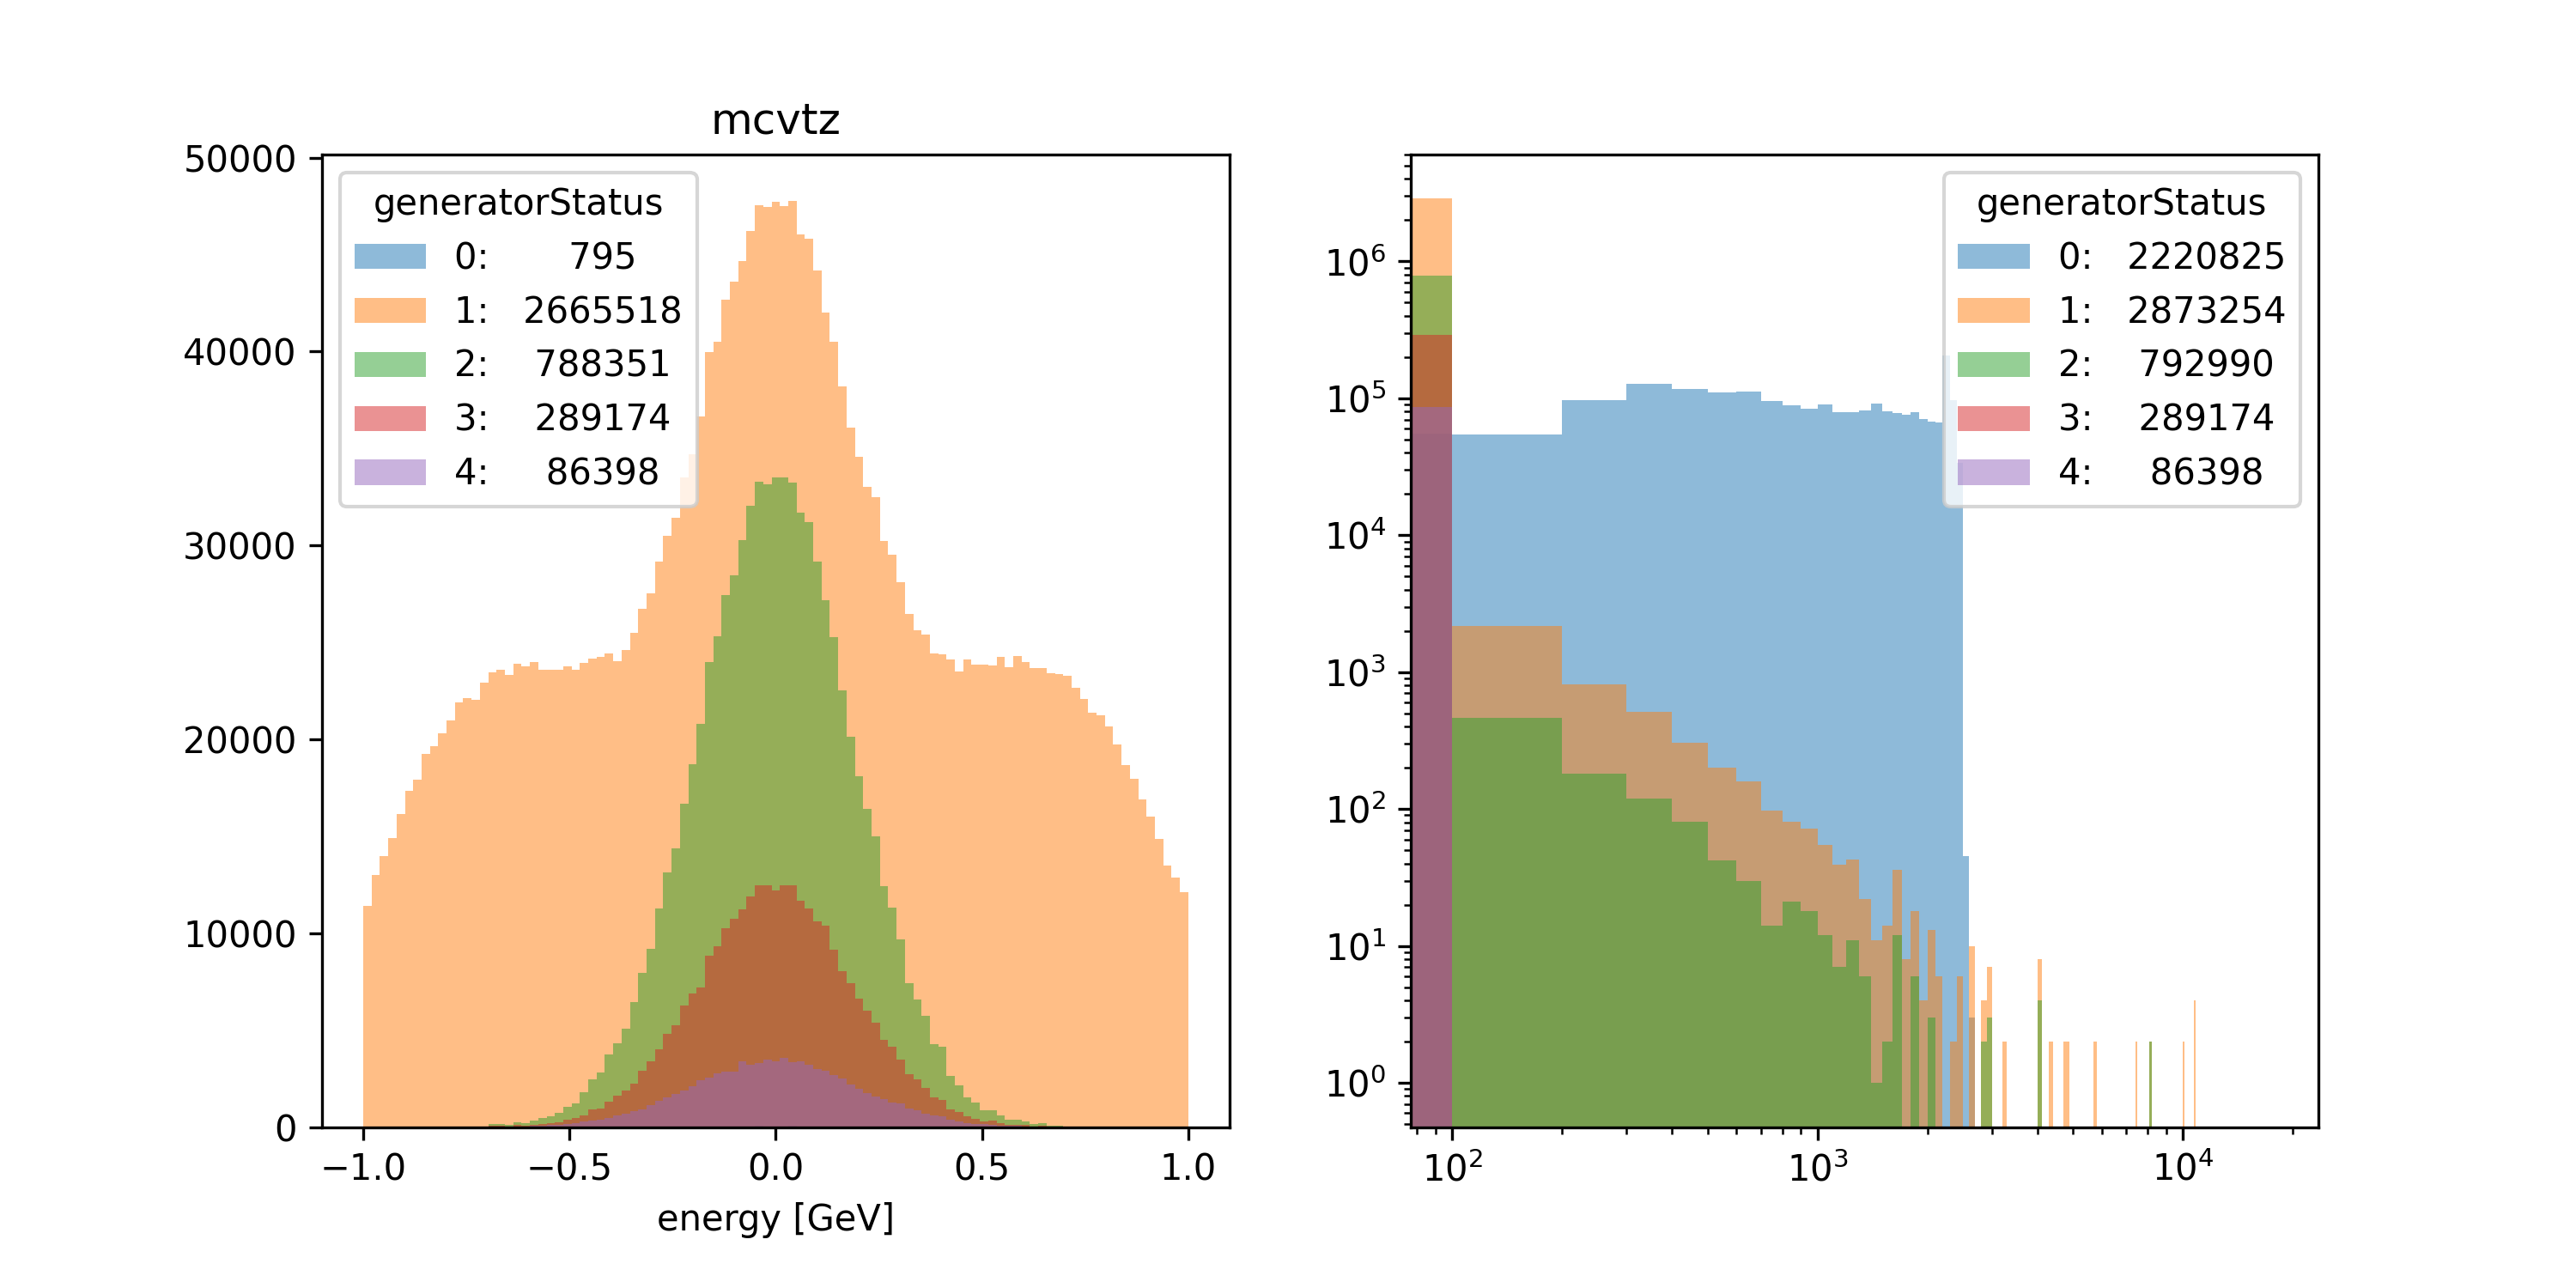

In [9]:
def var_per_generator_status(mc, var="mcepz"):
    vals = getattr(mc, var)
    bins1 = np.linspace(-1, 1, 100)
    bins2 = np.arange(0, ak.max(np.abs(vals)), 100)
    fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(10, 5))
    for i, gen_status in enumerate(range(5)):
        kw = dict(color=f"C{i}", alpha=0.5)
        x = ak.flatten(vals[mc.mcgst == gen_status])
        ax1.hist(
            x, bins=bins1, label=f"{gen_status}: {np.sum(np.abs(x) < 1):> 9}", **kw
        )
        ax2.hist(np.abs(x), bins=bins2, label=f"{gen_status}: {len(x):> 9}", **kw)
    ax1.set_title(var)
    ax1.set_xlabel("energy [GeV]")
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    ax1.legend(title="generatorStatus")
    ax2.legend(title="generatorStatus")
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    return (fig,)


def per_generator_status(var):
    x = getattr(mc, var)
    if all(x[0][0] == ak.flatten(x)):
        print(f"{var} only takes single value: {x[0][0]}")
        return

    @load_or_make([f"per_generator_status_{var}.png"])
    def var_plot(var, mc):
        return var_per_generator_status(mc, var)

    return var_plot(var, mc)


# for var in mc.fields:
#     per_generator_status(var);

per_generator_status("mcmoz")
per_generator_status("mcepz")
per_generator_status("mcepy")
per_generator_status("mcmoy")
per_generator_status("mcvtx")
per_generator_status("mcvty")
per_generator_status("mcvtz");